# Imports and fixing data

In [59]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from fontTools.merge import timer
from matplotlib.colors import ListedColormap
from scipy.signal import find_peaks
import numpy as np
import pandas as pd
import datetime

from collections import Counter

In [60]:
pd.__version__

'2.2.3'

In [61]:
pd.options.mode.copy_on_write = True

To make a new json file, do the following in this directory:
```
node convert_to_json.mjs PATH_TO_REALM.realm ./export.json
```

In [62]:
import json

# Open and read the JSON file
with open(("export.json"), 'r') as file:
# with open(("28-02-2025 07_49_03 mybaby-default.json"), 'r') as file:
    data = json.load(file)

full_df = pd.DataFrame.from_dict(data["EventItem"])
# full_df = full_df.set_index('id')

In [63]:
full_df.columns

Index(['id', 'babyId', 'comment', 'photo', 'type', 'enteredDate',
       'customComment', 'leftStart', 'leftEnd', 'rightStart', 'rightEnd',
       'leftSeconds', 'rightSeconds', 'mixType', 'bottleAmount',
       'bottleAmountOunce', 'weight', 'height', 'headCirc', 'temperature',
       'weightPounds', 'heightInches', 'headCircInches', 'temperatureFah',
       'breast', 'singleTimerStart', 'singleTimerSeconds',
       'doubleLeftTimerStart', 'doubleRightTimerStart',
       'doubleLeftTimerSeconds', 'doubleRightTimerSeconds'],
      dtype='object')

In [64]:
pd.unique(full_df.loc[:,"type"])

array(['lactation', 'bottle', 'pumping', 'taking_med', 'diaper',
       'temperature', 'vaccination', 'weight', 'height', 'head_circ',
       'bathing', 'sleep', 'custom_achieve', 'stroll', 'lure'],
      dtype=object)

## single instance

In [65]:
full_df.iloc[-1]

id                         09E89345-3600-4C6E-9B10-FAD3C782D031
babyId                     50269EA9-7196-43CC-AAC7-996E4154C610
comment                                                        
photo                                                      None
type                                                     bottle
enteredDate                            2025-04-17T01:30:37.000Z
customComment                                                  
leftStart                                                  None
leftEnd                                                    None
rightStart                                                 None
rightEnd                                                   None
leftSeconds                                                   0
rightSeconds                                                  0
mixType                                                 mixture
bottleAmount                                                180
bottleAmountOunce                       

## Fix date and numeric fields

In [66]:
date_fields = ['enteredDate', 'leftStart', 'leftEnd']
for field in date_fields:
    full_df[field] = pd.to_datetime(full_df[field], format='%Y-%m-%dT%H:%M:%S.%fZ').dt.tz_localize('UTC').dt.tz_convert('US/Eastern')
num_fields = ['leftSeconds',
              'rightSeconds', 
              'bottleAmount',
              'bottleAmountOunce', 
              'weight', 
              'height', 
              'headCirc' ,
              'temperature',
              'weightPounds',
              'heightInches',
              'headCircInches',
              'temperatureFah','singleTimerSeconds' ]
for field in num_fields:
    full_df[field] = pd.to_numeric(full_df[field])
    
sleep_err = 10*60 # 10 mins in seconds
bottle_err = 15 # ml

In [67]:
full_df.groupby('type').count()

,id,babyId,comment,photo,enteredDate,customComment,leftStart,leftEnd,rightStart,rightEnd,...,heightInches,headCircInches,temperatureFah,breast,singleTimerStart,singleTimerSeconds,doubleLeftTimerStart,doubleRightTimerStart,doubleLeftTimerSeconds,doubleRightTimerSeconds
type,,,,,,,,,,,,,,,,,,,,,
bathing,35,35,35,0,35,35,35,35,0,0,...,0,0,0,35,0,1,0,0,0,0
bottle,1391,1391,1391,0,1391,1391,0,0,0,0,...,0,0,0,1391,0,0,0,0,0,0
custom_achieve,1,1,1,0,1,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
diaper,272,272,272,0,272,272,0,0,0,0,...,0,0,0,272,0,0,0,0,0,0
head_circ,7,7,7,0,7,7,0,0,0,0,...,0,7,0,7,0,0,0,0,0,0
height,8,8,8,0,8,8,0,0,0,0,...,8,0,0,8,0,0,0,0,0,0
lactation,156,156,156,0,156,156,156,156,0,0,...,0,0,0,156,0,0,0,0,5,4
lure,52,52,52,0,52,52,0,0,0,0,...,0,0,0,52,0,0,0,0,0,0
pumping,328,328,328,0,328,328,0,0,0,0,...,0,0,0,328,0,0,0,0,0,0


In [68]:
non_empty_strings = full_df[full_df['customComment'].str.strip().str.len() > 0]


In [69]:
non_empty_strings

,id,babyId,comment,photo,type,enteredDate,customComment,leftStart,leftEnd,rightStart,...,heightInches,headCircInches,temperatureFah,breast,singleTimerStart,singleTimerSeconds,doubleLeftTimerStart,doubleRightTimerStart,doubleLeftTimerSeconds,doubleRightTimerSeconds
151,47907606-DEBC-415F-BBF5-29D8566623EA,50269EA9-7196-43CC-AAC7-996E4154C610,Gas\n,None,taking_med,2024-10-19 09:10:42-04:00,med_drops,NaT,NaT,None,...,NaN,NaN,NaN,,None,NaN,None,None,NaN,NaN
156,28405EC5-90DE-4F45-9EF4-09034D82F768,50269EA9-7196-43CC-AAC7-996E4154C610,Gas,None,taking_med,2024-10-19 22:30:24-04:00,med_drops,NaT,NaT,None,...,NaN,NaN,NaN,,None,NaN,None,None,NaN,NaN
173,7D411CE4-2E1D-492A-90A1-10BA2F0B2D78,50269EA9-7196-43CC-AAC7-996E4154C610,Gas,None,taking_med,2024-10-20 20:00:44-04:00,med_drops,NaT,NaT,None,...,NaN,NaN,NaN,,None,NaN,None,None,NaN,NaN
177,9AC2FF0A-F711-4DD3-ABFE-E6E812BBAA7E,50269EA9-7196-43CC-AAC7-996E4154C610,Gas,None,taking_med,2024-10-20 22:30:42-04:00,med_drops,NaT,NaT,None,...,NaN,NaN,NaN,,None,NaN,None,None,NaN,NaN
196,15711C94-D55C-4541-A27C-7F62FBBA0D0E,50269EA9-7196-43CC-AAC7-996E4154C610,Gas,None,taking_med,2024-10-21 22:30:12-04:00,med_drops,NaT,NaT,None,...,NaN,NaN,NaN,,None,NaN,None,None,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3270,499A9C67-EBEC-4AA3-B3BB-65C388E6C918,50269EA9-7196-43CC-AAC7-996E4154C610,,None,taking_med,2025-04-15 13:00:23-04:00,Tylenol,NaT,NaT,None,...,NaN,NaN,NaN,,None,NaN,None,None,NaN,NaN
3271,1C58435D-D727-4BC0-B2EB-16329C6AE8FA,50269EA9-7196-43CC-AAC7-996E4154C610,,None,lure,2025-04-15 12:15:53-04:00,Banana / water,NaT,NaT,None,...,NaN,NaN,NaN,,None,NaN,None,None,NaN,NaN
3279,4B225D0A-B9DF-4B6E-B02E-853B5A3EE7B0,50269EA9-7196-43CC-AAC7-996E4154C610,,None,taking_med,2025-04-15 06:45:03-04:00,Tylenol,NaT,NaT,None,...,NaN,NaN,NaN,,None,NaN,None,None,NaN,NaN
3280,5EA97959-71C7-469D-9ECF-8106A74D8A60,50269EA9-7196-43CC-AAC7-996E4154C610,,None,diaper,2025-04-15 05:30:26-04:00,dirty,NaT,NaT,None,...,NaN,NaN,NaN,,None,NaN,None,None,NaN,NaN


## Helper methods

In [70]:
def add_day_of_week(df, date_column):
    """
    Add a day of the week column to the DataFrame.
    
    Parameters:
    df (pd.DataFrame): The input DataFrame
    date_column (str): Name of the column containing dates
    
    Returns:
    pd.DataFrame: The DataFrame with an additional 'day_of_week' column
    """
    df.loc[:,'day_of_week'] = pd.to_datetime(df.loc[:,date_column]).dt.day_name()
    return df


def group_and_sum_by_day(df, date_column, sum_columns, err):
    """
    Group a DataFrame by day and sum specified columns.
    
    Parameters:
    df (pd.DataFrame): The input DataFrame
    date_column (str): Name of the column containing dates
    sum_columns (list): List of column names to sum
    
    Returns:
    pd.DataFrame: A new DataFrame grouped by day with summed columns
    """
    # Ensure the date column is in datetime format
    df.loc[:,date_column] = pd.to_datetime(df.loc[:,date_column])
    
    functions = ['sum', 'count']
    agg_dict = {}
    for param in sum_columns:
        for func in functions:
            agg_dict[f"{param}_{func}"] = (param, func)
    
    # Group by date (ignoring time) and sum specified columns
    grouped_df = df.groupby(df[date_column].dt.date)[sum_columns].agg(**agg_dict).reset_index()
    for param in sum_columns:
        grouped_df[f"{param}_err"] = err * grouped_df[f"{param}_count"].pow(1./2.)
    
    return grouped_df

def group_and_sum_durations_by_day(df, date_columns, err):
    """
    Group a DataFrame by day and sum specified columns.
    
    Parameters:
    df (pd.DataFrame): The input DataFrame
    date_column (list): Name of the column containing dates start and end
    
    Returns:
    pd.DataFrame: A new DataFrame grouped by day with summed columns
    """
    # Ensure the date column is in datetime format
    for date_col in date_columns: 
        df.loc[:,date_col] = pd.to_datetime(df.loc[:,date_col])
        
    df.loc[:,'event_duration'] = (df.loc[:,date_columns[1]] - df.loc[:,date_columns[0]]).dt.total_seconds()
    
    functions = ['sum', 'count']
    agg_dict = {}
    for func in functions:
        agg_dict[f"event_duration_{func}"] = ("event_duration", func)
    
    # Group by date (ignoring time) and sum specified columns
    grouped_df = df.groupby(df[date_columns[0]].dt.date)[['event_duration']].agg(**agg_dict).reset_index()
    grouped_df["event_duration_sum_err"] = err * grouped_df["event_duration_count"].pow(1./2.)
    
    return grouped_df


def group_and_mean_by_day_of_week(df, date_column, mean_columns, err):
    """
    Group a DataFrame by day and mean specified columns.
    
    Parameters:
    df (pd.DataFrame): The input DataFrame
    date_column (str): Name of the column containing dates
    sum_columns (list): List of column names to sum
    
    Returns:
    pd.DataFrame: A new DataFrame grouped by day with summed columns
    """
    # Ensure the date column is in datetime format
    df.loc[:,date_column] = pd.to_datetime(df.loc[:,date_column])
    day_of_week = add_day_of_week(df, date_column)
    
    functions = ['mean', 'std', 'count']
    agg_dict = {}
    for param in mean_columns:
        for func in functions:
            agg_dict[f"{param}_{func}"] = (param, func)
            
    # Group by day of week and mean specified columns
    grouped_df = df.groupby(day_of_week['day_of_week'])[mean_columns].agg(**agg_dict).reset_index()
    
    # error on mean of entries per weekday
    for param in mean_columns:
        grouped_df.loc[:,f"{param}_err"] = err / grouped_df.loc[:,f"{param}_count"].pow(1./2.)
    grouped_df = grouped_df.reindex([3,1,5,6,4,0,2])
    
    return grouped_df

def group_and_mean_sums_by_day_of_week(df, date_column, mean_columns, err):
    """
    Group a DataFrame by day and sum specified columns, then report mean in day of the week.
    
    Parameters:
    df (pd.DataFrame): The input DataFrame
    date_column (str): Name of the column containing dates
    mean_columns (list): List of column names to mean/sum
    
    Returns:
    pd.DataFrame: A new DataFrame grouped by day with meaned columns
    """
    # Ensure the date column is in datetime format
    df.loc[:,date_column] = pd.to_datetime(df.loc[:,date_column])
    
    functions = ['sum', 'count']
    agg_dict = {}
    for param in mean_columns:
        for func in functions:
            agg_dict[f"{param}_{func}"] = (param,func)
            
    # Group by date (ignoring time) and sum specified columns
    grouped_summed_by_day_df = df.groupby(df[date_column].dt.date)[mean_columns].agg(**agg_dict).reset_index()
    # _sum and _count are totals per day (usually <10)
    
    grouped_summed_by_day_df = add_day_of_week(grouped_summed_by_day_df, date_column)

    functions = ['mean', 'std', 'count']
    agg_dict = {}
    for param in mean_columns:
        for func in functions:
            agg_dict[f"{param}_sum_{func}"] = (f"{param}_sum",func)
        agg_dict[f"{param}_count_sum"] = (f"{param}_count","sum")
            
    # Group by day of week and mean specified columns
    grouped_on_sums_df = grouped_summed_by_day_df.groupby('day_of_week').agg(**agg_dict).reset_index()
    
    # _mean _std and _count are values for same weekday (which have been summed), i.e. mean of weekday sum.
    for param in mean_columns:
        # error = # sum/# week * err
        grouped_on_sums_df.loc[:,f"{param}_err"] = err * ( grouped_on_sums_df.loc[:,f"{param}_count_sum"].pow(1./2.) / grouped_on_sums_df.loc[:,f"{param}_count_sum"] )
    grouped_on_sums_df = grouped_on_sums_df.reindex([3,1,5,6,4,0,2])
    
    return grouped_on_sums_df

def group_and_sum_by_day_of_week(df, date_column, sum_columns):
    """
    Group a DataFrame by day of week and sum specified columns.
    
    Parameters:
    df (pd.DataFrame): The input DataFrame
    date_column (str): Name of the column containing dates
    sum_columns (list): List of column names to sum
    
    Returns:
    pd.DataFrame: A new DataFrame grouped by day of week with summed columns
    """
    # Ensure the date column is in datetime format
    df.loc[:,date_column] = pd.to_datetime(df.loc[:,date_column])
    day_of_week = add_day_of_week(df, date_column)
    
    functions = ['sum', 'count']
    agg_dict = {}
    for param in sum_columns:
        for func in functions:
            agg_dict[f"{param}_{func}"] = (param,func)
    
    # Group by date (ignoring time) and sum specified columns
    grouped_df = df.groupby(day_of_week.loc[:,'day_of_week'])[sum_columns].agg(**agg_dict).reset_index()
    for param in sum_columns:
        # error = err* # sum
        grouped_df.loc[:,f"{param}_err"] = err * grouped_df.loc[:,f"{param}_count"].pow(1./2.)
        
    grouped_df = grouped_df.reindex([3,1,5,6,4,0,2])
    
    return grouped_df

def filter_date_range(df, date_column, start_date, end_date):
    """
    Filter the DataFrame for a specific date range.
    
    Parameters:
    df (pd.DataFrame): The input DataFrame
    date_column (str): Name of the column containing dates
    start_date (str): Start date in 'YYYY-MM-DD' format
    end_date (str): End date in 'YYYY-MM-DD' format
    
    Returns:
    pd.DataFrame: The filtered DataFrame
    """
    df.loc[:,date_column] = pd.to_datetime(df.loc[:,date_column])
    mask = (df.loc[:,date_column] >= start_date) & (df.loc[:,date_column] <= end_date)
    return df.loc[mask]

# # Example usage:
# # Assuming you have a DataFrame 'df' with columns 'date', 'sales', and 'units'

# # Group and sum by day
# daily_totals = group_and_sum_by_day(full_df[full_df['type']=='bottle'], 'enteredDate', ['bottleAmount'])

# # Add day of week
# daily_totals_with_day = add_day_of_week(daily_totals, 'enteredDate')

# # day_of_week_totals = group_and_sum_by_day(daily_totals_with_day, 'day_of_week', ['bottleAmount'])

# # Filter for a specific date range
# filtered_df = filter_date_range(full_df, 'leftStart', '2025-01-01', '2025-01-31')


In [71]:
from scipy.optimize import curve_fit

def energy_model(t, E0, A, k, t0):
    return E0 + A * np.heaviside(t - t0, 1) * np.exp(-k * (t - t0))

# # Your data
# time = np.array([...])  # Time points
# calories = np.array([...])  # Calorie intake

# # Initial parameter guesses
# p0 = [min(calories), max(calories) - min(calories), 0.1, time[0]]

# # Fit the model
# popt, _ = curve_fit(energy_model, time, calories, p0=p0)

# # popt now contains the optimized parameters [E0, A, k, t0]


In [72]:
def categorize_day_night(df, start_time_col, end_time_col):
    """
    Categorize entries as day or night and create daytime and daytime_Time columns.
    
    Night is defined as 7 PM to 7 AM the next day, and is associated with the second day.
    
    Parameters:
    df (pd.DataFrame): The input DataFrame
    start_time_col (str): Name of the column containing start times
    end_time_col (str): Name of the column containing end times
    
    Returns:
    pd.DataFrame: The DataFrame with additional 'daytime' and 'daytime_Time' columns
    """
    # Ensure datetime format
    df.loc[:,start_time_col] = pd.to_datetime(df.loc[:,start_time_col])
    df.loc[:,end_time_col] = pd.to_datetime(df.loc[:,end_time_col])
    
    # Define night start and end times
    night_start = datetime.time(19, 0)  # 7 PM
    night_end = datetime.time(7, 0)    # 7 AM
    
    def categorize(row):
        start = row[start_time_col]
        end = row[end_time_col]
        
        # Check if the entry spans midnight
        spans_midnight = start.date() != end.date()
        
        # Determine if it's night time
        if spans_midnight:
            is_night = True
        elif start.time() >= night_start or end.time() <= night_end:
            is_night = True
        else:
            is_night = False
        
        # Assign daytime and date
        if is_night:
            return 'night', end.date()
        else:
            return 'day', start.date()
    
    # Apply the categorization
    df.loc[:,'daytime'], df.loc[:,'daytime_Time'] = zip(*df.loc[:,start_time_col].apply(categorize))
    
    return df

def categorize_day_night_start_only(df, start_time_col):
    """
    Categorize entries as day or night and create daytime and daytime_Time columns.
    
    Night is defined as 7 PM to 7 AM the next day, and is associated with the second day.
    
    Parameters:
    df (pd.DataFrame): The input DataFrame
    start_time_col (str): Name of the column containing start times
    
    Returns:
    pd.DataFrame: The DataFrame with additional 'daytime' and 'daytime_Time' columns
    """
    # Ensure datetime format
    df.loc[:,start_time_col] = pd.to_datetime(df.loc[:,start_time_col])
    
    # Define night start and end times
    night_start = datetime.time(19, 0)  # 7 PM
    night_end = datetime.time(7, 0)    # 7 AM
    
    def categorize(row):
        start = row[start_time_col]
        if night_start <= start.time() or start.time() < night_end:
            daytime = 'night'
            # If it's night and after midnight, use the same date
            # If it's night before midnight, use the next day's date
            daytime_time = start.date() if start.time() < night_end else start.date() + pd.Timedelta(days=1)
        else:
            daytime = 'day'
            daytime_time = start.date()
        
        return daytime, daytime_time
    
    # Apply the categorization
    result = df.apply(categorize, axis=1)

    # Assign values to each column separately
    df.loc[:, 'daytime'] = [r[0] for r in result]
    df.loc[:, 'daytime_Time'] = [r[1] for r in result]

    
    return df

# Example usage:
# Assuming you have a DataFrame 'df' with columns 'start_time' and 'end_time'
# df = categorize_day_night_start_only(full_df[full_df['type']=='sleep'], 'leftStart')

In [73]:
def get_type_data(df, entry_type ):
    return df.query(f"type == '{entry_type}'")

def get_timeperiod_data(df, period ):
    if 'daytime' in df:
        return df.query(f"daytime == '{period}'")
    else:
        return df

In [74]:
def get_plot_kwargs(period, plot_type='scatter',custom_label=None):
    base_kwargs = {
        'day': {'color': 'gold', 'label': 'day', 'ls': 'None', 'alpha': 0.7},
        'night': {'color': 'slateblue', 'label': 'night', 'ls': 'None', 'alpha': 0.7},
        'all': {'color': 'black', 'label': 'all', 'ls': 'None', 'alpha': 0.7}
    }
    
    if plot_type.lower() != 'histogram':
        for key in base_kwargs:
            base_kwargs[key]['marker'] = 'o'

    if custom_label:
        base_kwargs[period]['label']=custom_label
        
    return base_kwargs[period]

# Example usage:
# scatter_kwargs = get_plot_kwargs('scatter')
# histogram_kwargs = get_plot_kwargs('histogram')


In [75]:
def get_consecutive_durations_from_two_dfs(df1, df2, date_column='date', duration_column='duration'):
    """
    Returns durations from two DataFrames where df2's date is df1's date + 1 day.
    
    Parameters:
    df1 (pd.DataFrame): The first DataFrame 
    df2 (pd.DataFrame): The second DataFrame
    date_column (str): Name of the column containing dates
    duration_column (str): Name of the column containing durations
    
    Returns:
    list of tuples: Each tuple contains (df1_date, df1_duration, df2_date, df2_duration)
    """
    # Ensure both date columns are in datetime format
    df1[date_column] = pd.to_datetime(df1[date_column])
    df2[date_column] = pd.to_datetime(df2[date_column])
    
    # Sort both DataFrames by the date column
    df1 = df1.sort_values(date_column)
    df2 = df2.sort_values(date_column)
    
    # Create a dictionary mapping dates in df2 to their durations for fast lookup
    df2_date_to_duration = dict(zip(df2[date_column], df2[duration_column]))
    
    results = []
    
    # Iterate through each row in df1
    for _, row in df1.iterrows():
        current_date = row[date_column]
        next_date = current_date + pd.Timedelta(days=1)
        
        # Check if the next_date exists in df2
        if next_date in df2_date_to_duration:
            results.append((
                current_date,
                row[duration_column],
                next_date,
                df2_date_to_duration[next_date]
            ))
    
    return np.array(results)

In [76]:
def make_year_heatmap(dates):
    # Assuming your input is a pandas Series of datetime objects named 'dates_series'
    # If you don't have this, you can create a sample one like this:
    # dates_series = pd.Series([pd.Timestamp('2023-01-01'), pd.Timestamp('2023-01-01'), pd.Timestamp('2023-02-14'),
    #                           pd.Timestamp('2024-01-01'), pd.Timestamp('2024-03-15'),
    #                           pd.Timestamp('2025-05-20'), pd.Timestamp('2025-05-20'), pd.Timestamp('2025-12-31')])


    # Count occurrences of each date
    date_counts = Counter(dates)
    
    start_date = min(dates).replace(day=1)
    end_date = max(dates)
    total_weeks = (end_date - start_date).days // 7 + 1

    # Determine the range of years in the data
    min_year = min(date.year for date in dates)
    max_year = max(date.year for date in dates)
    num_years = max_year - min_year + 1

    # Create a 2D array to hold the data
    data = np.zeros((7, total_weeks))

    # Fill the data array
    for date, count in date_counts.items():
        week_num = (date - start_date).days // 7
        day_of_week = date.weekday()
        data[day_of_week, week_num] = count

    # Create the plot
    fig, ax = plt.subplots(figsize=(16, 4))

    # Create the heatmap
    heatmap = ax.imshow(data, cmap='YlOrRd', aspect='auto', interpolation='nearest')

    # Set up the y-axis labels (days of the week)
    ax.set_yticks(np.arange(7))
    ax.set_yticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])

    current_date = start_date
    for week in range(total_weeks):
        if current_date.day == 1 or week == 0 or current_date.day <=7:
            ax.text(week, -1, current_date.strftime('%b'), 
                    ha='center', va='center', fontsize=8)
        if current_date.month == 1 and current_date.day <= 7:
            ax.text(week, -1.5, str(current_date.year), 
                    ha='center', va='center', fontsize=10, fontweight='bold')
        current_date += datetime.timedelta(days=7)

    # Add colorbar
    cbar = plt.colorbar(heatmap)
    cbar.set_label('Count of occurrences')
    print(total_weeks)

    # Set xlabel
    plt.xlabel("Week #")
    
    # Set x-axis ticks to integers in increments of 5
    tick_positions = np.arange(0, total_weeks+1, 4)  # Start at 0, go to max(x), step by 5
    ax.set_xticks(tick_positions)

    # Format x-axis labels (optional: ensure they are integers)
    ax.set_xticklabels([str(int(tick)) for tick in tick_positions])
    
    # Set title and adjust layout
    plt.title('Date Occurrence Heatmap', y=1.2, pad=15)
    plt.tight_layout()

    # Show the plot
    plt.show()
    return ax


# Plots

## Feeding

### Daily feeding over time

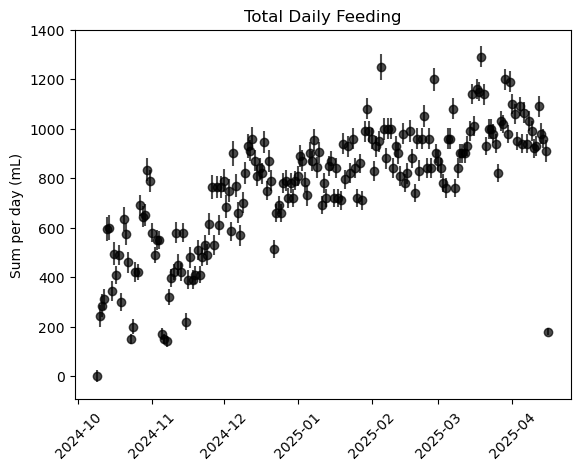

In [77]:
# Group and sum by day
filtered_df = filter_date_range(full_df, 'enteredDate', '2024-10-04', '2025-04-28')
df = categorize_day_night_start_only(get_type_data(filtered_df,'bottle'), 'enteredDate')
daily_totals = group_and_sum_by_day(df, 'enteredDate', ['bottleAmount'], err=bottle_err)

# Add day of week
daily_totals_with_day = add_day_of_week(daily_totals, 'enteredDate')
plt.errorbar(daily_totals.loc[:,'enteredDate'], 
             daily_totals.loc[:,'bottleAmount_sum'], 
             yerr=daily_totals.loc[:,'bottleAmount_err'], 
             **get_plot_kwargs('all') )
plt.xticks(rotation=45)
plt.title("Total Daily Feeding")
plt.ylabel("Sum per day (mL)")
plt.savefig("figures/total_daily_feeding.png")

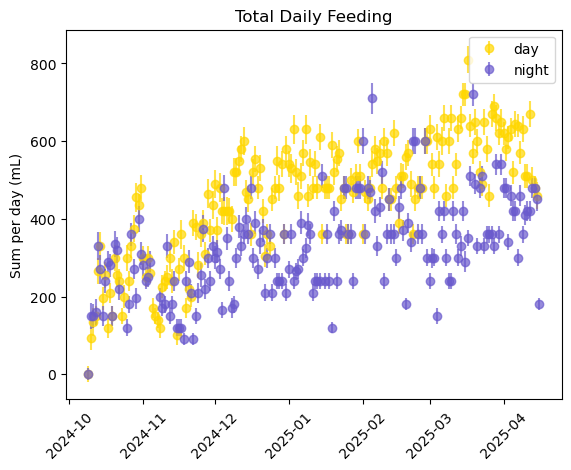

In [78]:
# Group and sum by day
df = categorize_day_night_start_only(get_type_data(full_df,'bottle'), 'enteredDate')
daily_totals = group_and_sum_by_day(df, 'enteredDate', ['bottleAmount'], err=bottle_err)

# # Add day of week
# daily_totals_with_day = add_day_of_week(daily_totals, 'enteredDate')
# plt.errorbar(daily_totals.loc[:,'enteredDate'], 
#              daily_totals.loc[:,'bottleAmount_sum'], 
#              yerr=daily_totals.loc[:,'bottleAmount_err'], 
#              **get_plot_kwargs('all') )

for period in ['day','night']:
    daily_totals = group_and_sum_by_day(get_timeperiod_data(df, period), 'enteredDate', ['bottleAmount'], err=bottle_err)

    # Add day of week
    daily_totals_with_day = add_day_of_week(daily_totals, 'enteredDate')
    plt.errorbar(daily_totals['enteredDate'], 
                 daily_totals['bottleAmount_sum'], 
                 yerr=daily_totals['bottleAmount_err'], 
                 **get_plot_kwargs(period))
plt.legend()
plt.xticks(rotation=45)
plt.title("Total Daily Feeding")
plt.ylabel("Sum per day (mL)")
plt.savefig("figures/total_daily_feeding_day_night.png")

/var/folders/74/3kz1j0p93vs_xz126s_l0f1h0000gq/T/ipykernel_81902/1266643045.py:17: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(energy_model, time, calories, p0=p0)


(array([20089.20833333, 20103.20833333, 20120.20833333, 20134.20833333,
        20148.20833333, 20162.16666667, 20179.16666667, 20193.16666667]),
 [Text(20089.208333333332, 0, '2025-01-01'),
  Text(20103.208333333332, 0, '2025-01-15'),
  Text(20120.208333333332, 0, '2025-02-01'),
  Text(20134.208333333332, 0, '2025-02-15'),
  Text(20148.208333333332, 0, '2025-03-01'),
  Text(20162.166666666668, 0, '2025-03-15'),
  Text(20179.166666666668, 0, '2025-04-01'),
  Text(20193.166666666668, 0, '2025-04-15')])

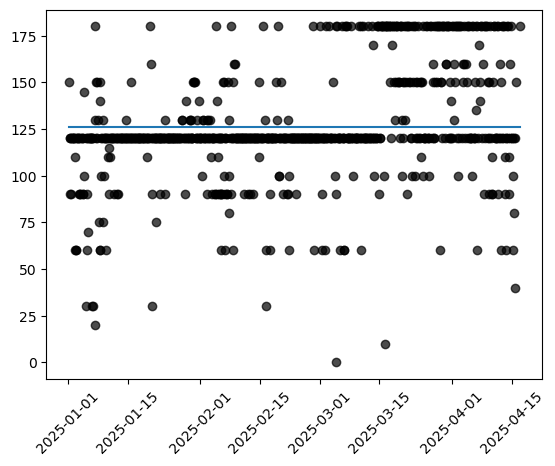

In [79]:
filtered_df = filter_date_range(full_df, 'enteredDate', '2025-01-01', '2025-04-28')
df = get_type_data(filtered_df,'bottle')
# plt.plot(df['enteredDate'], df['bottleAmount'],'o')

# Your data
# Assuming 'df' is your pandas DataFrame and 'your_datetime_column' is the column name
datetime_array = df.loc[:,'enteredDate'].to_numpy()
earliest_datetime = datetime_array.min()

time = [(d-earliest_datetime).total_seconds() for d in datetime_array]
calories = df.loc[:,'bottleAmount'].to_numpy()  # Calorie intake

# Initial parameter guesses
p0 = [min(calories), max(calories) - min(calories), 0.1, time[0]]

# Fit the model
popt, _ = curve_fit(energy_model, time, calories, p0=p0)

# popt now contains the optimized parameters [E0, A, k, t0]

plt.plot(datetime_array, energy_model(time, *popt))
plt.plot(datetime_array, calories, **get_plot_kwargs('all'))

plt.xticks(rotation=45)

In [80]:
def plot_fft_results(hourly_bins, hourly_counts, freq, power_spectrum):
    """
    Plot FFT results.

    Parameters:
    hourly_bins (pd.DatetimeIndex): The time bins used in FFT
    hourly_counts (pd.Series): Amplitude counts in each bin
    freq (np.array): Array of frequencies from FFT
    power_spectrum (np.array): Power spectrum from FFT

    Returns:
    tuple: fig, axes
    """
    # Plot original data
    fig1, ax1 = plt.subplots(figsize=(12, 4))
    ax1.bar(hourly_bins, hourly_counts, width=0.8, alpha=0.7, color='b')
    ax1.set_title('Original Time vs Amplitude Data')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Amplitude')
    plt.show()

    # Plot power spectrum
    fig2, ax2 = plt.subplots(figsize=(12, 4))
    positives = freq > 0
    period = (1 / freq)
    ax2.plot(freq[positives], power_spectrum[positives], color='b')
    ax2.set_title('Power Spectrum')
    ax2.set_xlabel('Period (min)')
    ax2.set_ylabel('Power')
    ax2.set_yscale('log')  # Log scale for better visibility of peaks
    ax2.set_xscale('log')
    plt.show()

    return (fig1, ax1), (fig2, ax2)

def plot_time_differences(differences, amplitudes, frequency):
    """
    Plot time differences from reference beat.

    Parameters:
    differences (np.array): Array of time differences
    amplitudes (pd.Series or np.array): Amplitudes corresponding to the times
    frequency (float): Reference frequency used for calculating the differences
    """
    plt.figure(figsize=(12, 6))
    plt.plot(differences / 3600, amplitudes, 'o')
    plt.title(f'Time Differences from Reference Beat (F={frequency:.2f} Hz)')
    plt.ylabel('Amplitude (ml)')
    plt.xlabel('Difference (hour)')
    plt.show()#%%
    return (fig1, ax1), (fig2, ax2)

In [81]:
def analyze_fft(df, time_col='start_time', amplitude_col='amplitude'):
    """
    Perform FFT on amplitude data and find peak frequencies.

    Parameters:
    df (pd.DataFrame): DataFrame containing the time and amplitude data
    time_col (str): Name of the column containing time data
    amplitude_col (str): Name of the column containing amplitude data

    Returns:
    tuple: (minute_bins, minute_counts, frequencies, power_spectrum, peak_frequencies)
    """
    # Ensure time data is in datetime format and sort
    df[time_col] = pd.to_datetime(df[time_col])
    df = df.sort_values(by=time_col)

    # Get min and max timestamps
    min_time = df[time_col].min()
    max_time = df[time_col].max()

    # Create time bins from min to max at minute intervals
    binning_time = 'min'  # Binning set to minutes
    time_bins = pd.date_range(start=min_time.floor(binning_time), end=max_time.ceil(binning_time), freq=binning_time)

    # Count events in each minute bin
    time_counts = pd.Series(0, index=time_bins)
    binned = df.groupby(pd.Grouper(key=time_col, freq=binning_time)).size().reindex(time_bins, fill_value=0)
    time_counts.update(binned)

    # Apply detrending to remove any linear trend in the data
    detrended_counts = time_counts - np.mean(time_counts)

    # Apply Hanning window to reduce spectral leakage
    hanning_window = np.hanning(len(detrended_counts))
    windowed_counts = detrended_counts * hanning_window

    # Perform FFT
    fft_result = np.fft.fft(windowed_counts)
    power_spectrum = np.abs(fft_result[:len(fft_result)//2]) ** 2  # Take positive frequencies only (real part)
    freq = np.fft.fftfreq(len(fft_result), d=60)[:len(fft_result)//2]  # Convert to frequencies in Hz (1/min)

    # Find peaks in the power spectrum
    peaks, _ = find_peaks(power_spectrum, height=np.max(power_spectrum) * 0.1)  # Peaks > 10% of the max
    peak_frequencies = freq[peaks]

    return time_bins, time_counts, freq, power_spectrum, peak_frequencies

In [82]:
time_bins, time_counts, freq, power_spectrum, peak_frequencies = analyze_fft(df,'enteredDate','bottleAmount')

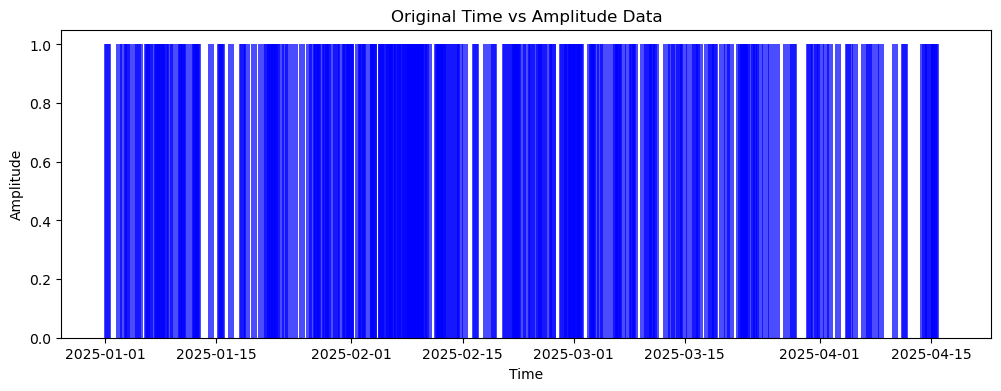

/var/folders/74/3kz1j0p93vs_xz126s_l0f1h0000gq/T/ipykernel_81902/1111118097.py:25: RuntimeWarning: divide by zero encountered in divide
  period = (1 / freq)


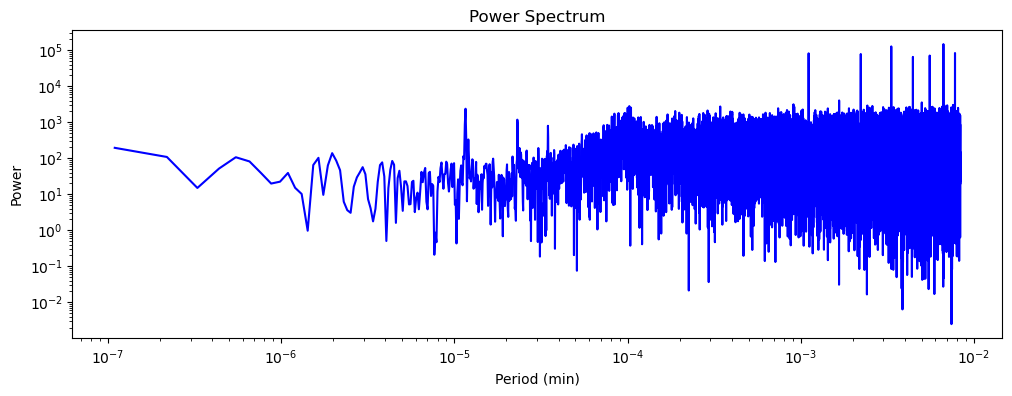

In [83]:
(fig1, ax1), (fig2, ax2) = plot_fft_results(time_bins[::20], time_counts[::20], freq, power_spectrum)

In [84]:
# Report the top 5 peak frequencies
top_5_peak_frequencies = peak_frequencies[np.argsort(power_spectrum[np.isin(freq, peak_frequencies)])][-5:]
print(f"Top 5 peak frequencies are: {(1/top_5_peak_frequencies[::-1])/60}")

Top 5 peak frequencies are: [ 2.49999178  5.00006573  2.14285513 15.0001972   7.5000986 ]


### Feeding per day of week

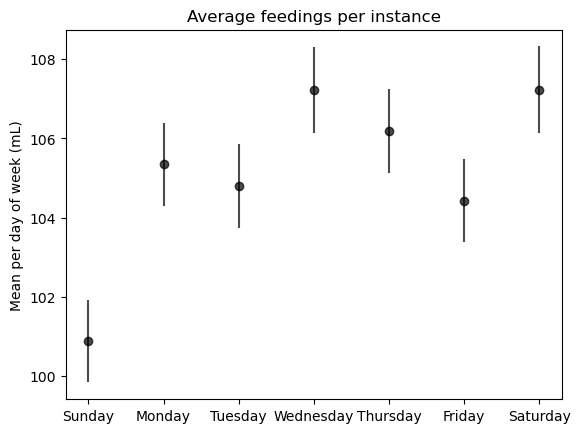

In [85]:
# Group and sum by day
daily_means = group_and_mean_by_day_of_week(get_type_data(full_df,'bottle'), 'enteredDate', ['bottleAmount'], bottle_err)

plt.errorbar(daily_means['day_of_week'], 
             daily_means['bottleAmount_mean'], 
             yerr=daily_means['bottleAmount_err'], 
            **get_plot_kwargs('all'))
plt.title("Average feedings per instance")
plt.ylabel("Mean per day of week (mL)")
plt.savefig("figures/average_feeding_instance_week.png")

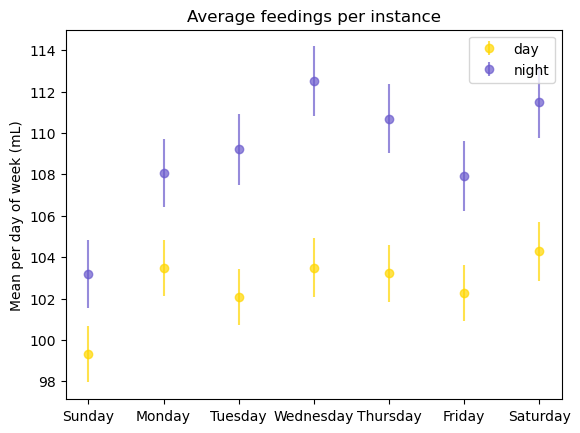

In [86]:
# Group and sum by day

df = categorize_day_night_start_only(get_type_data(full_df,'bottle'), 'enteredDate')

for period in ['day','night']:
    daily_means = group_and_mean_by_day_of_week(get_timeperiod_data(df,period), 'enteredDate', ['bottleAmount'], bottle_err)

    plt.errorbar(daily_means['day_of_week'], 
                 daily_means['bottleAmount_mean'], 
                 yerr=daily_means['bottleAmount_err'], 
                 **get_plot_kwargs(period))


plt.legend()
plt.title("Average feedings per instance")
plt.ylabel("Mean per day of week (mL)")
plt.savefig("figures/average_feeding_instance_week_day_night.png")

In [87]:
df = get_type_data(full_df,'bottle')
date_range = pd.date_range(start=df['enteredDate'].min().date(), end=df['enteredDate'].max().date())

/var/folders/74/3kz1j0p93vs_xz126s_l0f1h0000gq/T/ipykernel_81902/3494082576.py:14: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  time_range = pd.date_range(start='00:00', end='23:59', freq='15T').time


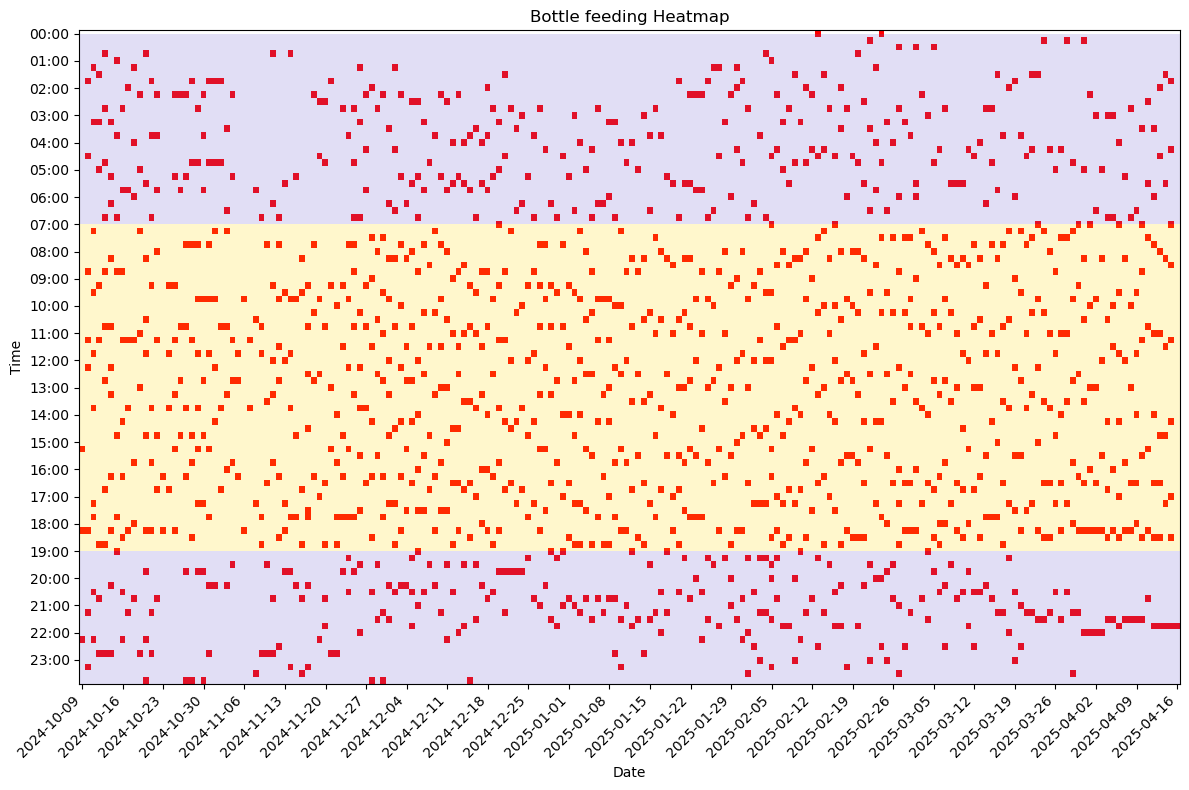

In [88]:
# Assuming you have a DataFrame 'df' with columns 'leftStart' and 'leftEnd'
# If not, you can create a sample DataFrame like this:
# df = pd.DataFrame({
#     'leftStart': pd.date_range(start='2023-01-01 09:00', end='2023-01-10 09:00', freq='D'),
#     'leftEnd': pd.date_range(start='2023-01-01 17:00', end='2023-01-10 17:00', freq='D')
# })

# Create a date range for x-axis
# filtered_df = filter_date_range(full_df, 'leftStart', '2025-03-01', '2025-03-06')
df = get_type_data(full_df,'bottle')
date_range = pd.date_range(start=df['enteredDate'].min().date(), end=df['enteredDate'].max().date())

# Create time range for y-axis (24 hours, in 15-minute intervals)
time_range = pd.date_range(start='00:00', end='23:59', freq='15T').time

# Create a 2D array to hold the heatmap data
heatmap_data = np.zeros((len(time_range), len(date_range)))

# Fill the heatmap data
for _, row in df.iterrows():
    start_date = row['enteredDate'].date()
    end_date = (row['enteredDate']+pd.Timedelta(15,'min')).date()
    start_time = row['enteredDate'].time()
    end_time = (row['enteredDate']+pd.Timedelta(15,'min')).time()
    # print(f"{row['leftStart']} to {row['leftEnd']} {row['leftEnd']-row['leftStart']}")
    
    date_idx_start = np.where(date_range.normalize() == pd.Timestamp(start_date).normalize())[0][0]
    date_idx_end = np.where(date_range.normalize() == pd.Timestamp(end_date).normalize())[0][0]
    
    start_idx = time_range.searchsorted(start_time)
    end_idx = time_range.searchsorted(end_time)
    
    if date_idx_start == date_idx_end:
        heatmap_data[start_idx:end_idx, date_idx_start] = 1
    else:
        heatmap_data[start_idx:, date_idx_start] = 1
        heatmap_data[:end_idx, date_idx_end] = 1
        if date_idx_end - date_idx_start > 1:
            heatmap_data[:, date_idx_start+1:date_idx_end] = 1

# Create the plot
fig, ax = plt.subplots(figsize=(12, 8))

# Add horizontal bands
ax.axhspan(0, 7 * 4, facecolor='slateblue', alpha=0.2)  # 0-7 hours (4 steps per hour)
ax.axhspan(7 * 4, 19 * 4, facecolor='gold', alpha=0.2)  # 7-19 hours
ax.axhspan(19 * 4, 24 * 4, facecolor='slateblue', alpha=0.2)  # 19-24 hours

# Create custom colormap (white for 0, blue for 1)
cmap = ListedColormap(['none', 'red'])

# Plot the heatmap
im = ax.imshow(heatmap_data, aspect='auto', cmap=cmap, interpolation='nearest')

# Set x-axis ticks and labels
num_dates = len(date_range)
tick_interval = 7 #num_dates // 25 # Use integer division to get 1/4 of the ticks
tick_positions = np.arange(0, num_dates, tick_interval)
ax.set_xticks(tick_positions)
ax.set_xticklabels(date_range[tick_positions].strftime('%Y-%m-%d'), rotation=45, ha='right')

# Set y-axis ticks and labels (every hour)
hour_indices = np.arange(0, len(time_range), 4)
ax.set_yticks(hour_indices)
ax.set_yticklabels([t.strftime('%H:%M') for t in time_range[hour_indices]])

# Set labels and title
ax.set_xlabel('Date')
ax.set_ylabel('Time')
ax.set_title('Bottle feeding Heatmap')

# Adjust layout and display the plot
plt.tight_layout()

plt.savefig("figures/bottle_map.png")
plt.show()

/var/folders/74/3kz1j0p93vs_xz126s_l0f1h0000gq/T/ipykernel_81902/66222490.py:14: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  time_range = pd.date_range(start='00:00', end='23:59', freq='15T').time


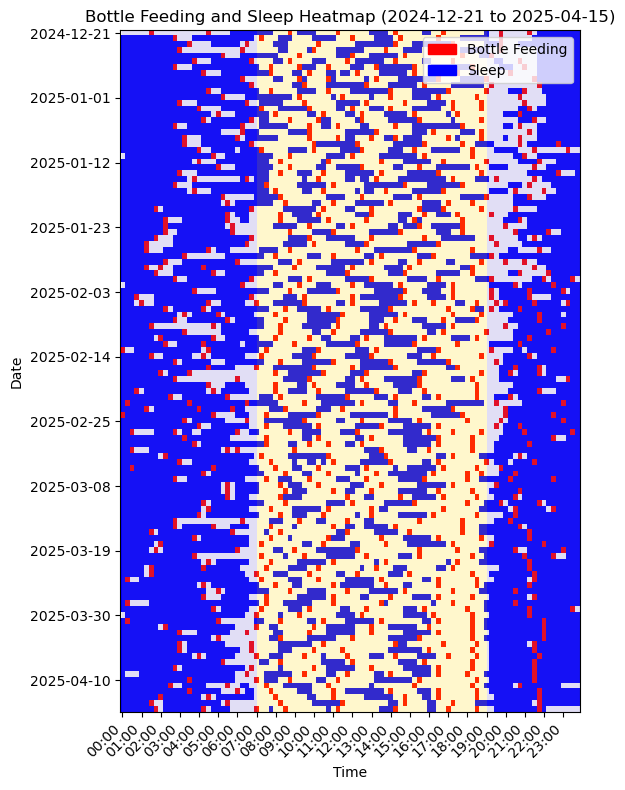

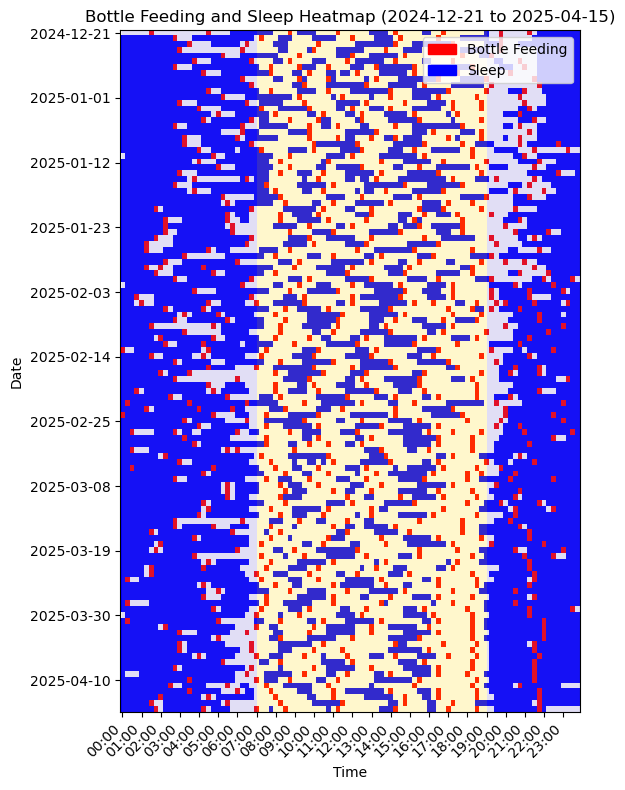

In [89]:
# First, get the combined date range across both DataFrames
df_bottle = get_type_data(full_df, 'bottle')
df_sleep = get_type_data(full_df, 'sleep')

# Get the combined min and max dates from both DataFrames
min_date = min(df_bottle['enteredDate'].min().date(), df_sleep['leftStart'].min().date())
max_date = max((df_bottle['enteredDate'] + pd.Timedelta(15, 'min')).max().date(), 
               df_sleep['leftEnd'].max().date())

# Create a unified date range for both heatmaps
date_range = pd.date_range(start=min_date, end=max_date)

# Create time range for y-axis (24 hours, in 15-minute intervals)
time_range = pd.date_range(start='00:00', end='23:59', freq='15T').time

# Create 2D arrays with the same dimensions for both heatmaps
heatmap_data_bottle = np.zeros((len(time_range), len(date_range)))
heatmap_data_sleep = np.zeros((len(time_range), len(date_range)))

# Fill the bottle feeding heatmap data
for _, row in df_bottle.iterrows():
    start_date = row['enteredDate'].date()
    end_date = (row['enteredDate'] + pd.Timedelta(15, 'min')).date()
    start_time = row['enteredDate'].time()
    end_time = (row['enteredDate'] + pd.Timedelta(15, 'min')).time()
    
    date_idx_start = np.where(date_range.normalize() == pd.Timestamp(start_date).normalize())[0][0]
    date_idx_end = np.where(date_range.normalize() == pd.Timestamp(end_date).normalize())[0][0]
    
    start_idx = time_range.searchsorted(start_time)
    end_idx = time_range.searchsorted(end_time)
    
    if date_idx_start == date_idx_end:
        heatmap_data_bottle[start_idx:end_idx, date_idx_start] = 1
    else:
        heatmap_data_bottle[start_idx:, date_idx_start] = 1
        heatmap_data_bottle[:end_idx, date_idx_end] = 1
        if date_idx_end - date_idx_start > 1:
            heatmap_data_bottle[:, date_idx_start+1:date_idx_end] = 1

# Fill the sleep heatmap data 
for _, row in df_sleep.iterrows():
    start_date = row['leftStart'].date()
    end_date = row['leftEnd'].date()
    start_time = row['leftStart'].time()
    end_time = row['leftEnd'].time()
    
    date_idx_start = np.where(date_range.normalize() == pd.Timestamp(start_date).normalize())[0][0]
    date_idx_end = np.where(date_range.normalize() == pd.Timestamp(end_date).normalize())[0][0]
    
    start_idx = time_range.searchsorted(start_time)
    end_idx = time_range.searchsorted(end_time)
    
    if date_idx_start == date_idx_end:
        heatmap_data_sleep[start_idx:end_idx, date_idx_start] = 1
    else:
        heatmap_data_sleep[start_idx:, date_idx_start] = 1
        heatmap_data_sleep[:end_idx, date_idx_end] = 1
        if date_idx_end - date_idx_start > 1:
            heatmap_data_sleep[:, date_idx_start+1:date_idx_end] = 1

# Function to limit the display to a specific date range
def plot_heatmap_with_date_range(start_date_str='2025-01-01', end_date_str='2025-05-31'):
    # Convert string dates to datetime objects
    start_date = pd.Timestamp(start_date_str).date()
    end_date = pd.Timestamp(end_date_str).date()
    
    # Find the indices for the specified date range
    start_idx = np.where(date_range.date >= start_date)[0]
    end_idx = np.where(date_range.date <= end_date)[0]
    
    if len(start_idx) == 0 or len(end_idx) == 0:
        print(f"Warning: Specified date range {start_date_str} to {end_date_str} is outside the available data range.")
        return
    
    start_idx = start_idx[0]
    end_idx = end_idx[-1]
    
    # Extract the portion of the heatmap data for the specified date range
    date_slice = slice(start_idx, end_idx + 1)
    limited_date_range = date_range[date_slice]
    limited_heatmap_bottle = heatmap_data_bottle[:, date_slice]
    limited_heatmap_sleep = heatmap_data_sleep[:, date_slice]
    
    # TRANSPOSE THE DATA
    limited_heatmap_bottle_T = limited_heatmap_bottle.T
    limited_heatmap_sleep_T = limited_heatmap_sleep.T
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(6, 8))
    
    # Add vertical bands instead of horizontal
    # We need to convert the hour ranges to indices in the time array
    morning_start = 0  # 0:00
    morning_end = 7 * 4  # 7:00 (4 steps per hour)
    evening_start = 19 * 4  # 19:00
    evening_end = len(time_range)  # 23:59
    
    ax.axvspan(morning_start, morning_end, facecolor='slateblue', alpha=0.2)  # 0-7 hours
    ax.axvspan(morning_end, evening_start, facecolor='gold', alpha=0.2)  # 7-19 hours
    ax.axvspan(evening_start, evening_end, facecolor='slateblue', alpha=0.2)  # 19-24 hours
    
    # Create custom colormaps
    # For sleep data - white for 0, blue for 1
    cmap_sleep = ListedColormap(['white', 'blue'])
    
    # For bottle data - transparent for 0, green for 1
    cmap_bottle = ListedColormap(['none', 'red'])  # 'none' makes the 0 values transparent
    
    # Plot sleep heatmap first (as the background)
    im_sleep = ax.imshow(limited_heatmap_sleep_T, aspect='auto', cmap=cmap_sleep, interpolation='nearest')
    
    # Then plot bottle heatmap with transparency for zeros
    im_bottle = ax.imshow(limited_heatmap_bottle_T, aspect='auto', cmap=cmap_bottle, interpolation='nearest')
    
    # Set y-axis ticks and labels
    num_dates = len(limited_date_range)
    # Adjust tick interval based on the range length
    tick_interval = max(1, num_dates // 10)  # Show at most ~10 date labels
    tick_positions = np.arange(0, num_dates, tick_interval)
    ax.set_yticks(tick_positions)
    ax.set_yticklabels(limited_date_range[tick_positions].strftime('%Y-%m-%d'))
    
    # Set x-axis ticks and labels (every hour)
    hour_indices = np.arange(0, len(time_range), 4)
    ax.set_xticks(hour_indices)
    ax.set_xticklabels([t.strftime('%H:%M') for t in time_range[hour_indices]], rotation=45, ha='right')
    
    # Set labels and title
    ax.set_xlabel('Time')
    ax.set_ylabel('Date')
    ax.set_title(f'Bottle Feeding and Sleep Heatmap ({start_date_str} to {end_date_str})')
    
    # Add a legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='red', edgecolor='red', label='Bottle Feeding'),
        Patch(facecolor='blue', edgecolor='blue', label='Sleep')
    ]
    ax.legend(handles=legend_elements, loc='upper right')
    
    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()
    return ax

# Usage example:
# Plot for a specific date range
ax = plot_heatmap_with_date_range('2024-12-21', '2025-04-15')

plt.sca(ax)
plt.savefig("figures/bottle_sleep_heatmap.png")
# Or to plot the entire range
# plot_heatmap_with_date_range(min_date.strftime('%Y-%m-%d'), max_date.strftime('%Y-%m-%d'))

## Sleeping

### Sleep Durations

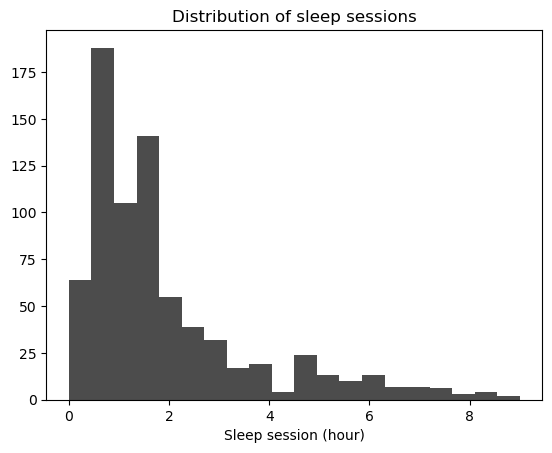

In [90]:
sleep_durations = get_type_data(full_df,'sleep')[['singleTimerSeconds']].values

plt.hist(sleep_durations/3600, bins=20, **get_plot_kwargs('all', plot_type='histogram'))
plt.xlabel("Sleep session (hour)")
plt.title("Distribution of sleep sessions")
plt.savefig("figures/sleep_dist.png")

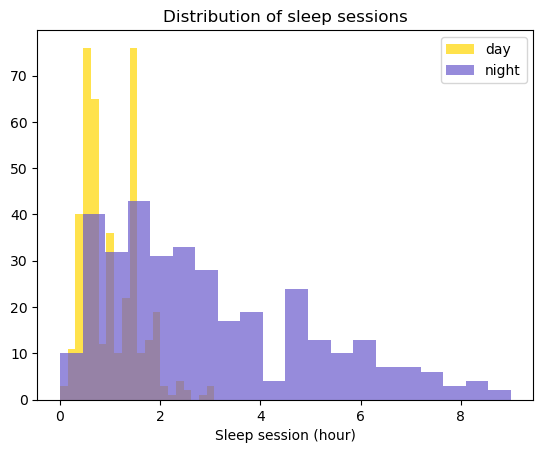

In [91]:
df = categorize_day_night_start_only(get_type_data(full_df,'sleep'), 'leftStart')
for period in ['day','night']:
    sleep_durations = get_timeperiod_data(df,period)[['singleTimerSeconds']].values
    plt.hist(sleep_durations/3600, bins=20, **get_plot_kwargs(period, plot_type='histogram'))

plt.legend()
plt.xlabel("Sleep session (hour)")
plt.title("Distribution of sleep sessions")
plt.savefig("figures/sleep_dist_day_night.png")

### Sleep over time, per day

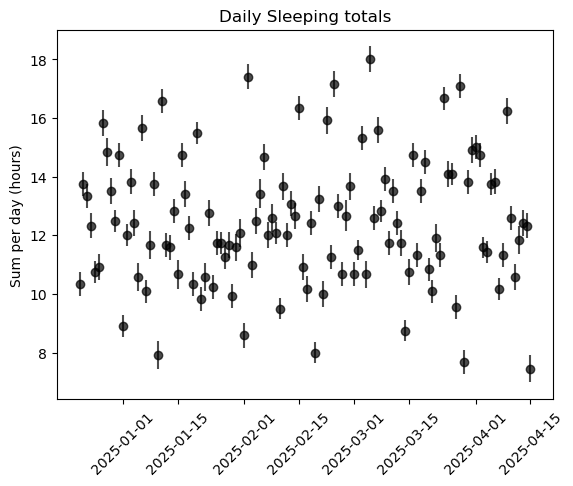

In [92]:
# Group and sum by day
daily_totals = group_and_sum_by_day(get_type_data(full_df,'sleep'), 'leftStart', ['singleTimerSeconds'], err=sleep_err)

# Add day of week
daily_totals_with_day = add_day_of_week(daily_totals, 'leftStart')

plt.errorbar(daily_totals['leftStart'], 
             daily_totals['singleTimerSeconds_sum']/3600, 
             yerr=daily_totals['singleTimerSeconds_err']/3600,
             **get_plot_kwargs('all'))
plt.title("Daily Sleeping totals")
plt.xticks(rotation=45)
plt.ylabel("Sum per day (hours)")
plt.savefig("figures/daily_sleep.png")

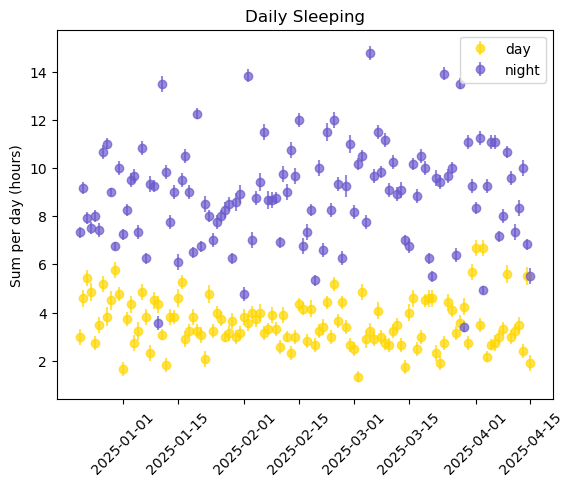

In [93]:
# Group and sum by day
df = categorize_day_night_start_only(get_type_data(full_df,'sleep'), 'leftStart')

for period in ['day','night']:
    daily_totals = group_and_sum_by_day(get_timeperiod_data(df,period), 'leftStart', ['singleTimerSeconds'], err=sleep_err)
    plt.errorbar(daily_totals['leftStart'], 
                 daily_totals['singleTimerSeconds_sum']/3600, 
                 yerr=daily_totals['singleTimerSeconds_err']/3600,
                 **get_plot_kwargs(period))
plt.legend()
plt.xticks(rotation=45)
plt.title("Daily Sleeping")
plt.ylabel("Sum per day (hours)")
plt.savefig("figures/daily_sleep_day_night.png")

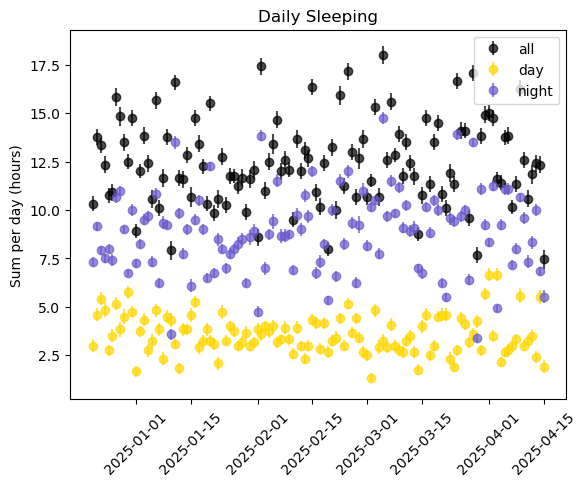

In [94]:
# Group and sum by day
daily_totals = group_and_sum_by_day(get_type_data(full_df,'sleep'), 'leftStart', ['singleTimerSeconds'], err=sleep_err)

# Add day of week
daily_totals_with_day = add_day_of_week(daily_totals, 'leftStart')

plt.errorbar(daily_totals['leftStart'], 
             daily_totals['singleTimerSeconds_sum']/3600, 
             yerr=daily_totals['singleTimerSeconds_err']/3600,
             **get_plot_kwargs('all'))

# Group and sum by day
df = categorize_day_night_start_only(get_type_data(full_df,'sleep'), 'leftStart')

for period in ['day','night']:
    daily_totals = group_and_sum_by_day(get_timeperiod_data(df,period), 'leftStart', ['singleTimerSeconds'], err=sleep_err)
    plt.errorbar(daily_totals['leftStart'], 
                 daily_totals['singleTimerSeconds_sum']/3600, 
                 yerr=daily_totals['singleTimerSeconds_err']/3600,
                 **get_plot_kwargs(period))
plt.legend()
plt.xticks(rotation=45)
plt.title("Daily Sleeping")
plt.ylabel("Sum per day (hours)")
plt.savefig("figures/daily_sleep_day_night_all.png")

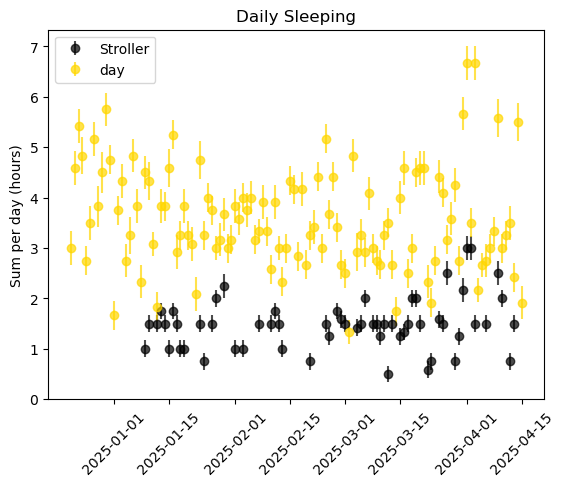

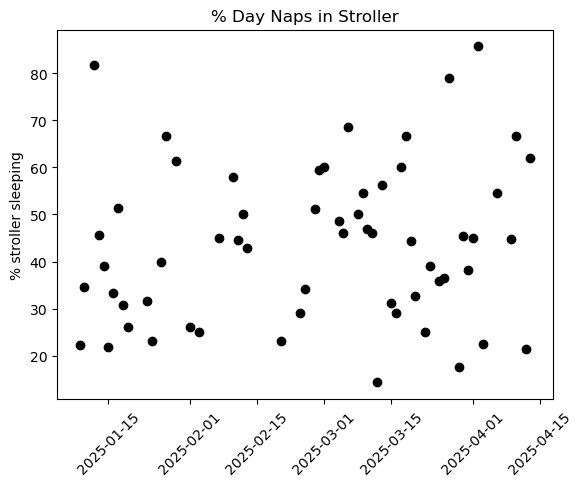

In [95]:
# Group and sum by day
daily_totals_stroller = group_and_sum_durations_by_day(get_type_data(full_df,'stroll'), ['leftStart','leftEnd'], err=sleep_err)

# Add day of week
daily_totals_stroller_with_day = add_day_of_week(daily_totals_stroller, 'leftStart')

plt.errorbar(daily_totals_stroller['leftStart'], 
             daily_totals_stroller['event_duration_sum']/3600, 
             yerr=daily_totals_stroller['event_duration_sum_err']/3600,
             **get_plot_kwargs('all',custom_label='Stroller'))

# Group and sum by day
df = categorize_day_night_start_only(get_type_data(full_df,'sleep'), 'leftStart')

for period in ['day']:
    daily_totals = group_and_sum_by_day(get_timeperiod_data(df,period), 'leftStart', ['singleTimerSeconds'], err=sleep_err)
    plt.errorbar(daily_totals['leftStart'], 
                 daily_totals['singleTimerSeconds_sum']/3600, 
                 yerr=daily_totals['singleTimerSeconds_err']/3600,
                 **get_plot_kwargs(period))
plt.legend()
plt.title("Daily Sleeping")
plt.xticks(rotation=45)
plt.ylabel("Sum per day (hours)")
plt.savefig("figures/daily_sleep_stroller.png")

merged_df = pd.merge(daily_totals_stroller, daily_totals,'inner')
plt.figure()
plt.plot(merged_df['leftStart'],
         merged_df['event_duration_sum']/merged_df['singleTimerSeconds_sum']*100,
         marker='o',
         color='k', ls='None'
        )
plt.ylabel("% stroller sleeping")
plt.xticks(rotation=45)
plt.title("% Day Naps in Stroller")
plt.savefig("figures/daily_sleep_stroller_percent.png")

### Sleep per day of week

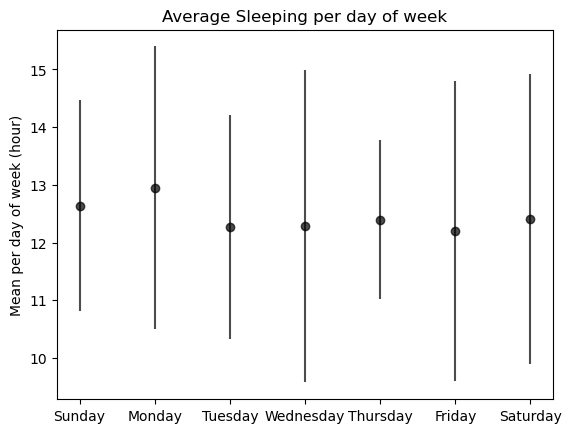

In [96]:
# Group and sum by day
daily_means = group_and_mean_sums_by_day_of_week(get_type_data(full_df,'sleep'), 'leftStart', ['singleTimerSeconds'],sleep_err)

plt.errorbar(daily_means['day_of_week'], 
             daily_means['singleTimerSeconds_sum_mean']/3600, 
             yerr=daily_means['singleTimerSeconds_sum_std']/3600, 
             **get_plot_kwargs('all'))
plt.title("Average Sleeping per day of week")
plt.ylabel("Mean per day of week (hour)")
plt.savefig("figures/sleep_per_weekday.png")

### How does sum of night sleep impact sum of following day's sleep. Plot night sum vs day sum. Is there a trend line?

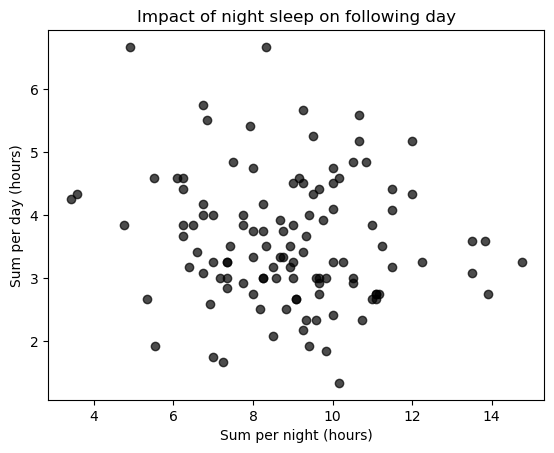

In [97]:
# Group and sum by day
df = categorize_day_night_start_only(get_type_data(full_df,'sleep'), 'leftStart')
daily_totals_night = group_and_sum_by_day(get_timeperiod_data(df, 'night'), 'leftStart', ['singleTimerSeconds'], err=sleep_err)
daily_totals_day = group_and_sum_by_day(get_timeperiod_data(df,'day'), 'leftStart', ['singleTimerSeconds'], err=sleep_err)
plt.plot(daily_totals_night['singleTimerSeconds_sum']/3600, 
         daily_totals_day['singleTimerSeconds_sum']/3600, 
             **get_plot_kwargs('all'))

plt.title("Impact of night sleep on following day")
plt.xlabel("Sum per night (hours)")
plt.ylabel("Sum per day (hours)")
plt.savefig("figures/sleep_night_on_day.png")

### How does sum of day sleep impact sum of following night's sleep. Plot day sum vs night sum. Is there a trend line?

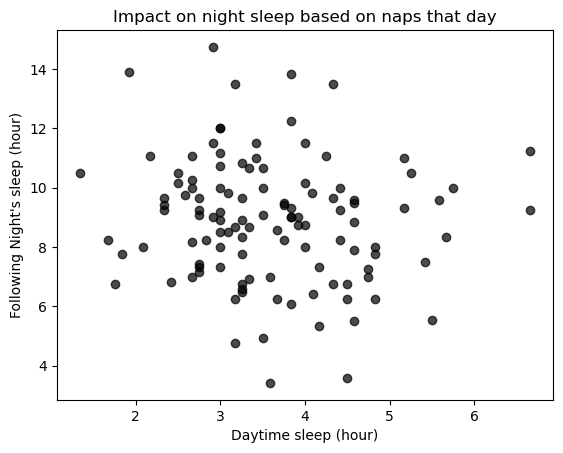

In [98]:
# Group and sum by day

df = categorize_day_night_start_only(get_type_data(full_df,'sleep'), 'leftStart')

daily_totals_night = group_and_sum_by_day(get_timeperiod_data(df, 'night'), 'leftStart', ['singleTimerSeconds'], err=sleep_err)
daily_totals_day = group_and_sum_by_day(get_timeperiod_data(df,'day'), 'leftStart', ['singleTimerSeconds'], err=sleep_err)

results = get_consecutive_durations_from_two_dfs(daily_totals_day, daily_totals_night, date_column='leftStart', duration_column='singleTimerSeconds_sum')
plt.plot(results[:,1]/3600,results[:,3]/3600,**get_plot_kwargs('all'))

plt.xlabel("Daytime sleep (hour)")
plt.ylabel("Following Night's sleep (hour)")
plt.title("Impact on night sleep based on naps that day")
plt.savefig("figures/sleep_day_on_night.png")

/var/folders/74/3kz1j0p93vs_xz126s_l0f1h0000gq/T/ipykernel_81902/3335003140.py:14: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  time_range = pd.date_range(start='00:00', end='23:59', freq='15T').time


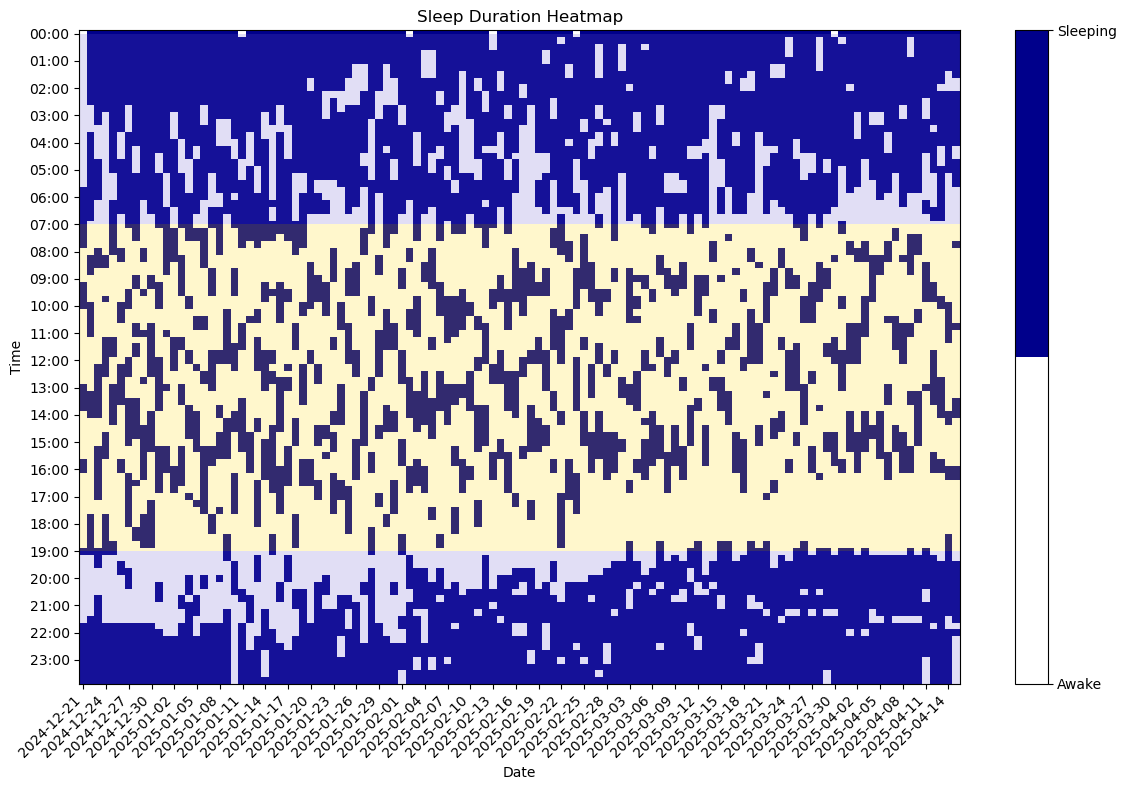

In [99]:
# Assuming you have a DataFrame 'df' with columns 'leftStart' and 'leftEnd'
# If not, you can create a sample DataFrame like this:
# df = pd.DataFrame({
#     'leftStart': pd.date_range(start='2023-01-01 09:00', end='2023-01-10 09:00', freq='D'),
#     'leftEnd': pd.date_range(start='2023-01-01 17:00', end='2023-01-10 17:00', freq='D')
# })

# Create a date range for x-axis
# filtered_df = filter_date_range(full_df, 'leftStart', '2025-03-01', '2025-03-06')
df = get_type_data(full_df,'sleep')
date_range = pd.date_range(start=df['leftStart'].min().date(), end=df['leftEnd'].max().date())

# Create time range for y-axis (24 hours, in 15-minute intervals)
time_range = pd.date_range(start='00:00', end='23:59', freq='15T').time

# Create a 2D array to hold the heatmap data
heatmap_data = np.zeros((len(time_range), len(date_range)))

# Fill the heatmap data
for _, row in df.iterrows():
    start_date = row['leftStart'].date()
    end_date = row['leftEnd'].date()
    start_time = row['leftStart'].time()
    end_time = row['leftEnd'].time()
    # print(f"{row['leftStart']} to {row['leftEnd']} {row['leftEnd']-row['leftStart']}")
    
    date_idx_start = np.where(date_range.normalize() == pd.Timestamp(start_date).normalize())[0][0]
    date_idx_end = np.where(date_range.normalize() == pd.Timestamp(end_date).normalize())[0][0]
    
    start_idx = time_range.searchsorted(start_time)
    end_idx = time_range.searchsorted(end_time)
    
    if date_idx_start == date_idx_end:
        heatmap_data[start_idx:end_idx, date_idx_start] = 1
    else:
        heatmap_data[start_idx:, date_idx_start] = 1
        heatmap_data[:end_idx, date_idx_end] = 1
        if date_idx_end - date_idx_start > 1:
            heatmap_data[:, date_idx_start+1:date_idx_end] = 1

# Create the plot
fig, ax = plt.subplots(figsize=(12, 8))

# Add horizontal bands
ax.axhspan(0, 7 * 4, facecolor='slateblue', alpha=0.2)  # 0-7 hours (4 steps per hour)
ax.axhspan(7 * 4, 19 * 4, facecolor='gold', alpha=0.2)  # 7-19 hours
ax.axhspan(19 * 4, 24 * 4, facecolor='slateblue', alpha=0.2)  # 19-24 hours

# Create custom colormap (white for 0, blue for 1)
cmap = ListedColormap(['white', 'darkblue'])

# Plot the heatmap
im = ax.imshow(heatmap_data, aspect='auto', cmap=cmap, interpolation='nearest')

# Set x-axis ticks and labels
num_dates = len(date_range)
tick_interval = 3 #num_dates // 25 # Use integer division to get 1/4 of the ticks
tick_positions = np.arange(0, num_dates, tick_interval)
ax.set_xticks(tick_positions)
ax.set_xticklabels(date_range[tick_positions].strftime('%Y-%m-%d'), rotation=45, ha='right')

# Set y-axis ticks and labels (every hour)
hour_indices = np.arange(0, len(time_range), 4)
ax.set_yticks(hour_indices)
ax.set_yticklabels([t.strftime('%H:%M') for t in time_range[hour_indices]])

# Set labels and title
ax.set_xlabel('Date')
ax.set_ylabel('Time')
ax.set_title('Sleep Duration Heatmap')

# Add colorbar
cbar = plt.colorbar(im, ax=ax, ticks=[0, 1])
cbar.set_ticklabels(['Awake', 'Sleeping'])

# Adjust layout and display the plot
plt.tight_layout()

plt.savefig("figures/sleep_map.png")
plt.show()

/var/folders/74/3kz1j0p93vs_xz126s_l0f1h0000gq/T/ipykernel_81902/1873953830.py:14: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  time_range = pd.date_range(start='00:00', end='23:59', freq='15T').time


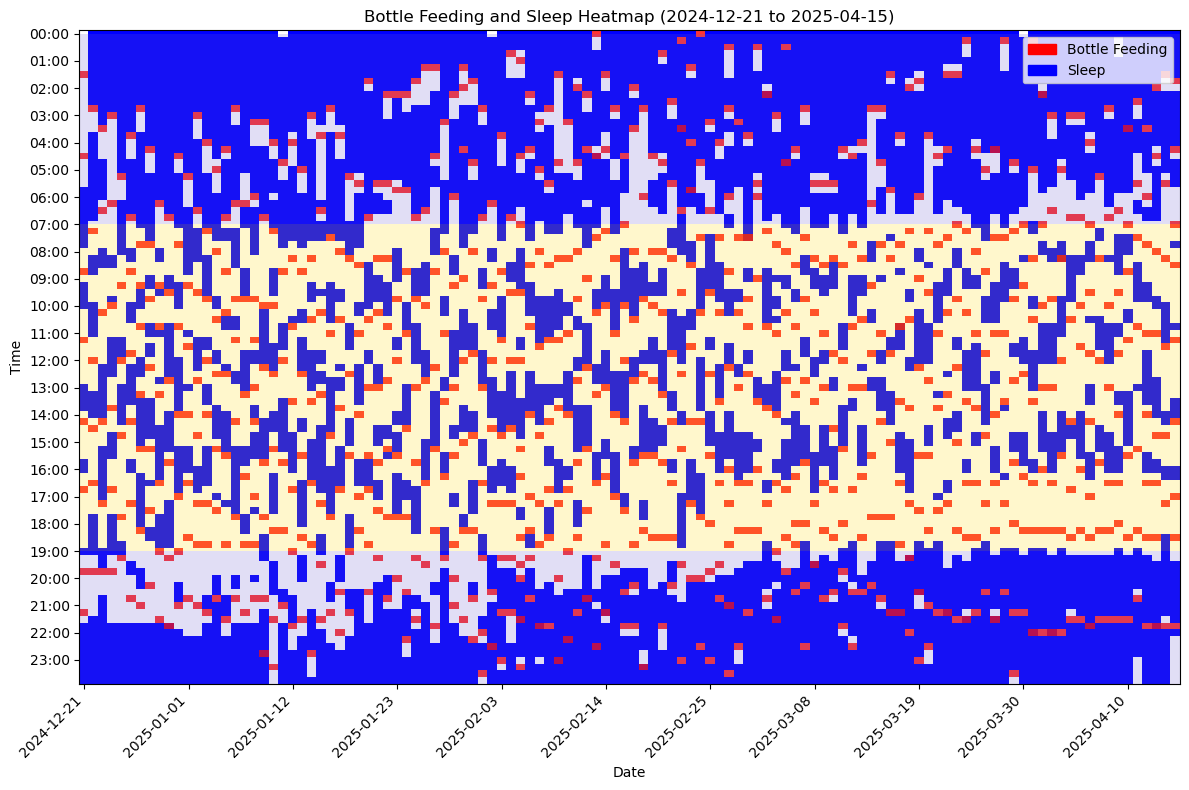

In [100]:
# First, get the combined date range across both DataFrames
df_bottle = get_type_data(full_df, 'bottle')
df_sleep = get_type_data(full_df, 'sleep')

# Get the combined min and max dates from both DataFrames
min_date = min(df_bottle['enteredDate'].min().date(), df_sleep['leftStart'].min().date())
max_date = max((df_bottle['enteredDate'] + pd.Timedelta(15, 'min')).max().date(), 
               df_sleep['leftEnd'].max().date())

# Create a unified date range for both heatmaps
date_range = pd.date_range(start=min_date, end=max_date)

# Create time range for y-axis (24 hours, in 15-minute intervals)
time_range = pd.date_range(start='00:00', end='23:59', freq='15T').time

# Create 2D arrays with the same dimensions for both heatmaps
heatmap_data_bottle = np.zeros((len(time_range), len(date_range)))
heatmap_data_sleep = np.zeros((len(time_range), len(date_range)))

# Fill the bottle feeding heatmap data
for _, row in df_bottle.iterrows():
    start_date = row['enteredDate'].date()
    end_date = (row['enteredDate'] + pd.Timedelta(15, 'min')).date()
    start_time = row['enteredDate'].time()
    end_time = (row['enteredDate'] + pd.Timedelta(15, 'min')).time()
    
    date_idx_start = np.where(date_range.normalize() == pd.Timestamp(start_date).normalize())[0][0]
    date_idx_end = np.where(date_range.normalize() == pd.Timestamp(end_date).normalize())[0][0]
    
    start_idx = time_range.searchsorted(start_time)
    end_idx = time_range.searchsorted(end_time)
    
    if date_idx_start == date_idx_end:
        heatmap_data_bottle[start_idx:end_idx, date_idx_start] = 1
    else:
        heatmap_data_bottle[start_idx:, date_idx_start] = 1
        heatmap_data_bottle[:end_idx, date_idx_end] = 1
        if date_idx_end - date_idx_start > 1:
            heatmap_data_bottle[:, date_idx_start+1:date_idx_end] = 1

# Fill the sleep heatmap data 
for _, row in df_sleep.iterrows():
    start_date = row['leftStart'].date()
    end_date = row['leftEnd'].date()
    start_time = row['leftStart'].time()
    end_time = row['leftEnd'].time()
    
    date_idx_start = np.where(date_range.normalize() == pd.Timestamp(start_date).normalize())[0][0]
    date_idx_end = np.where(date_range.normalize() == pd.Timestamp(end_date).normalize())[0][0]
    
    start_idx = time_range.searchsorted(start_time)
    end_idx = time_range.searchsorted(end_time)
    
    if date_idx_start == date_idx_end:
        heatmap_data_sleep[start_idx:end_idx, date_idx_start] = 1
    else:
        heatmap_data_sleep[start_idx:, date_idx_start] = 1
        heatmap_data_sleep[:end_idx, date_idx_end] = 1
        if date_idx_end - date_idx_start > 1:
            heatmap_data_sleep[:, date_idx_start+1:date_idx_end] = 1

# Function to limit the display to a specific date range
def plot_heatmap_with_date_range(start_date_str='2024-01-01', end_date_str='2025-05-31'):
    # Convert string dates to datetime objects
    start_date = pd.Timestamp(start_date_str).date()
    end_date = pd.Timestamp(end_date_str).date()
    
    # Find the indices for the specified date range
    start_idx = np.where(date_range.date >= start_date)[0]
    end_idx = np.where(date_range.date <= end_date)[0]
    
    if len(start_idx) == 0 or len(end_idx) == 0:
        print(f"Warning: Specified date range {start_date_str} to {end_date_str} is outside the available data range.")
        return
    
    start_idx = start_idx[0]
    end_idx = end_idx[-1]
    
    # Extract the portion of the heatmap data for the specified date range
    date_slice = slice(start_idx, end_idx + 1)
    limited_date_range = date_range[date_slice]
    limited_heatmap_bottle = heatmap_data_bottle[:, date_slice]
    limited_heatmap_sleep = heatmap_data_sleep[:, date_slice]
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Add horizontal bands
    ax.axhspan(0, 7 * 4, facecolor='slateblue', alpha=0.2)  # 0-7 hours (4 steps per hour)
    ax.axhspan(7 * 4, 19 * 4, facecolor='gold', alpha=0.2)  # 7-19 hours
    ax.axhspan(19 * 4, 24 * 4, facecolor='slateblue', alpha=0.2)  # 19-24 hours
    
    # Create custom colormaps
    cmap_bottle = ListedColormap(['none', 'red'])
    cmap_sleep = ListedColormap(['white', 'blue'])
    
    # Plot both heatmaps
    im_sleep = ax.imshow(limited_heatmap_sleep, aspect='auto', cmap=cmap_sleep, interpolation='nearest')
    im_bottle = ax.imshow(limited_heatmap_bottle, aspect='auto', cmap=cmap_bottle, interpolation='nearest', alpha=0.8)
    
    # Set x-axis ticks and labels
    num_dates = len(limited_date_range)
    # Adjust tick interval based on the range length
    tick_interval = max(1, num_dates // 10)  # Show at most ~10 date labels
    tick_positions = np.arange(0, num_dates, tick_interval)
    ax.set_xticks(tick_positions)
    ax.set_xticklabels(limited_date_range[tick_positions].strftime('%Y-%m-%d'), rotation=45, ha='right')
    
    # Set y-axis ticks and labels (every hour)
    hour_indices = np.arange(0, len(time_range), 4)
    ax.set_yticks(hour_indices)
    ax.set_yticklabels([t.strftime('%H:%M') for t in time_range[hour_indices]])
    
    # Set labels and title
    ax.set_xlabel('Date')
    ax.set_ylabel('Time')
    ax.set_title(f'Bottle Feeding and Sleep Heatmap ({start_date_str} to {end_date_str})')
    
    # Add a legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='red', edgecolor='red', label='Bottle Feeding'),
        Patch(facecolor='blue', edgecolor='blue', label='Sleep')
    ]
    ax.legend(handles=legend_elements, loc='upper right')
    
    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()

# Usage example:
# Plot for a specific date range
plot_heatmap_with_date_range('2024-12-21', '2025-04-15')

# Or to plot the entire range
# plot_heatmap_with_date_range(min_date.strftime('%Y-%m-%d'), max_date.strftime('%Y-%m-%d'))

In [101]:
combined_df = full_df[(full_df['type']=='sleep') | (full_df['type']=='bottle')]
combined_df['combined_date'] = combined_df.apply(lambda row: row['leftStart'] if row['type'] == 'sleep' else row['enteredDate'], axis=1)
combined_df['combined_date'] = pd.to_datetime(combined_df['combined_date'])
df_sorted = combined_df.sort_values(by='combined_date')



(400.0, 600.0)

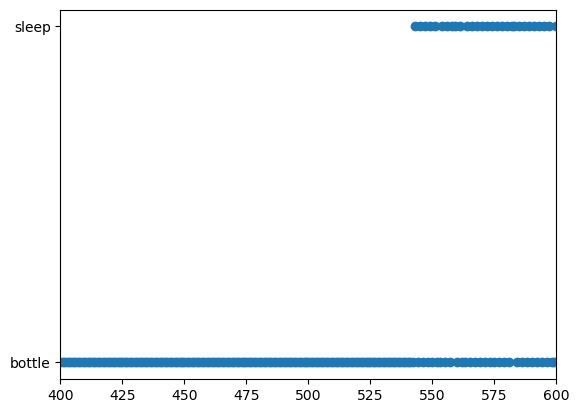

In [102]:
plt.plot(df_sorted['type'].values,'o')
plt.xlim(400,600)

## Vitals

### Growth

/var/folders/74/3kz1j0p93vs_xz126s_l0f1h0000gq/T/ipykernel_81902/2108994442.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels(labels, rotation=45, ha='right')
/var/folders/74/3kz1j0p93vs_xz126s_l0f1h0000gq/T/ipykernel_81902/2108994442.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels(labels, rotation=45, ha='right')
/var/folders/74/3kz1j0p93vs_xz126s_l0f1h0000gq/T/ipykernel_81902/2108994442.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels(labels, rotation=45, ha='right')


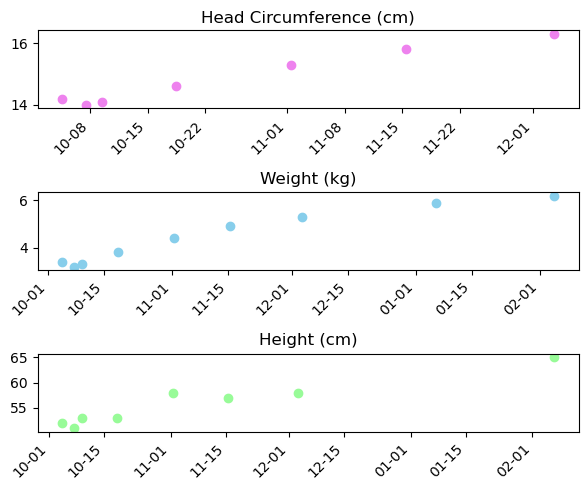

In [103]:
head_circ = get_type_data(full_df,"head_circ")[['enteredDate','headCircInches']]
weight = get_type_data(full_df,"weight")[['enteredDate','weight']]
height = get_type_data(full_df,"height")[['enteredDate','height']]

fig,ax=plt.subplots(3,1, figsize=(6,5))

ax[0].plot(head_circ.values[:,0], head_circ.values[:,1], label='head_circ',marker='o',ls='None', c='violet')
ax[1].plot(weight.values[:,0], weight.values[:,1], label='weight',marker='o',ls='None', c='skyblue')
ax[2].plot(height.values[:,0], height.values[:,1], label='height',marker='o',ls='None', c='palegreen')


ax[0].set_title("Head Circumference (cm)",)
ax[1].set_title("Weight (kg)")
ax[2].set_title("Height (cm)")

date_formatter = mdates.DateFormatter("%m-%d")
for i in range(3):
    # Format x-axis to show only month-day
    ax[i].xaxis.set_major_formatter(date_formatter)

    # Get current tick labels
    labels = ax[i].get_xticklabels()

    # Set the rotated labels
    ax[i].set_xticklabels(labels, rotation=45, ha='right')
    # ax[i].set_xticklabels(ax[i].get_xticks(), rotation = 45)

plt.tight_layout()
plt.savefig("figures/growth.png")

In [104]:
get_type_data(full_df,"height")[['enteredDate','height']]

,enteredDate,height
992,2024-10-04 12:00:55-04:00,52.0
993,2024-10-07 12:00:22-04:00,51.0
994,2024-10-09 12:00:44-04:00,53.0
995,2024-10-18 12:00:04-04:00,53.0
996,2024-11-01 12:00:21-04:00,58.0
997,2024-11-15 12:00:44-05:00,57.0
998,2024-12-03 12:00:04-05:00,58.0
2088,2025-02-06 11:33:52.852000-05:00,65.0


In [105]:
get_type_data(full_df,"height")[['enteredDate','height']].values[:,0]

array([Timestamp('2024-10-04 12:00:55-0400', tz='US/Eastern'),
       Timestamp('2024-10-07 12:00:22-0400', tz='US/Eastern'),
       Timestamp('2024-10-09 12:00:44-0400', tz='US/Eastern'),
       Timestamp('2024-10-18 12:00:04-0400', tz='US/Eastern'),
       Timestamp('2024-11-01 12:00:21-0400', tz='US/Eastern'),
       Timestamp('2024-11-15 12:00:44-0500', tz='US/Eastern'),
       Timestamp('2024-12-03 12:00:04-0500', tz='US/Eastern'),
       Timestamp('2025-02-06 11:33:52.852000-0500', tz='US/Eastern')],
      dtype=object)

## Wellbeing

### Baths

20


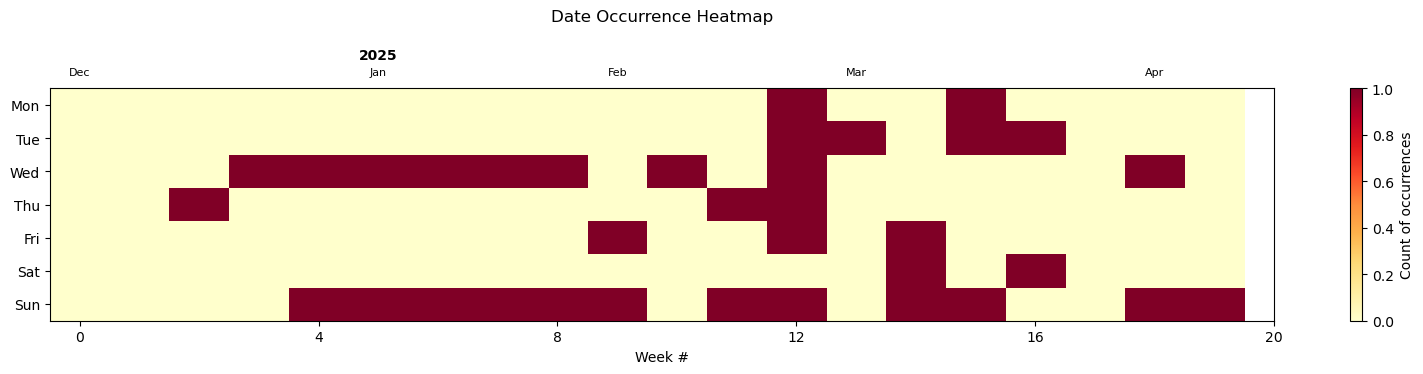

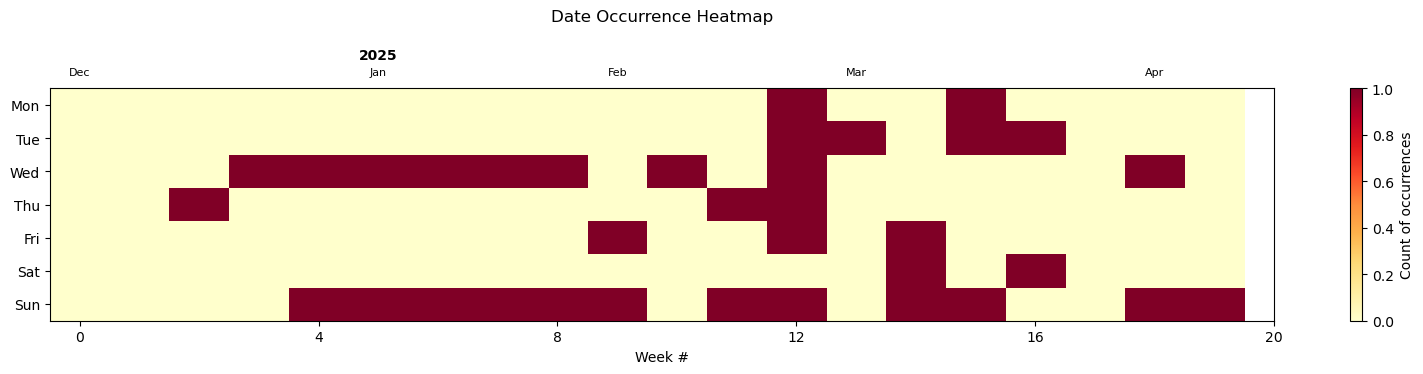

In [106]:
# Convert Series to list of dates
dates = get_type_data(full_df,"bathing")['enteredDate'].dt.date
ax = make_year_heatmap(dates)
plt.sca(ax)
plt.savefig("figures/bath_map.png")

### Gas Drops

29


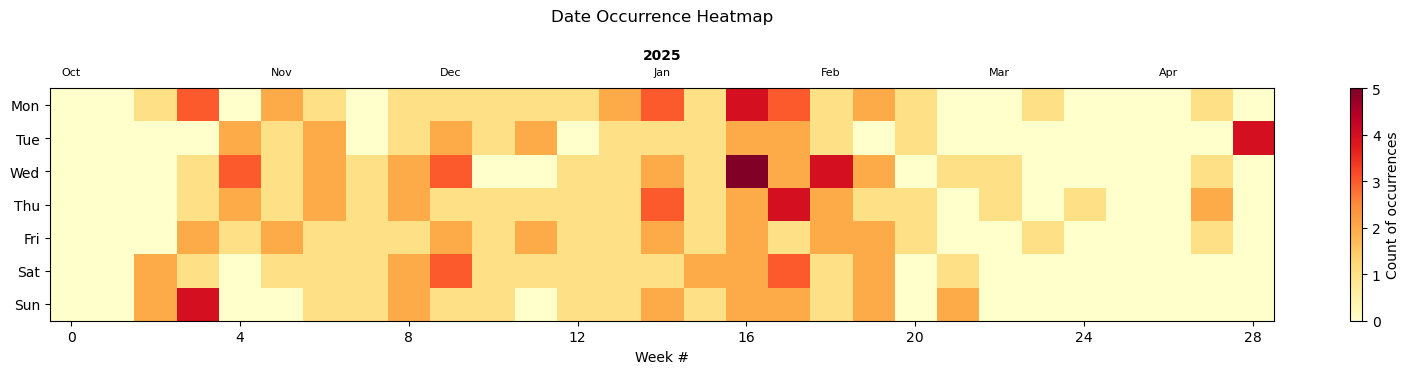

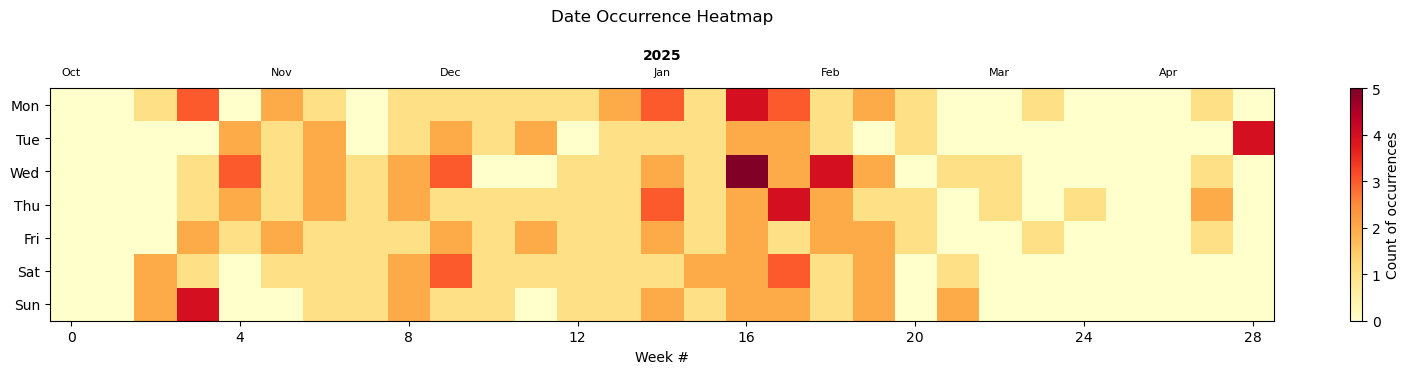

In [107]:
# Convert Series to list of dates
dates = get_type_data(full_df,"taking_med")['enteredDate'].dt.date
ax = make_year_heatmap(dates)
plt.sca(ax)
plt.savefig("figures/gas_drops_map.png")

### Diapers

29


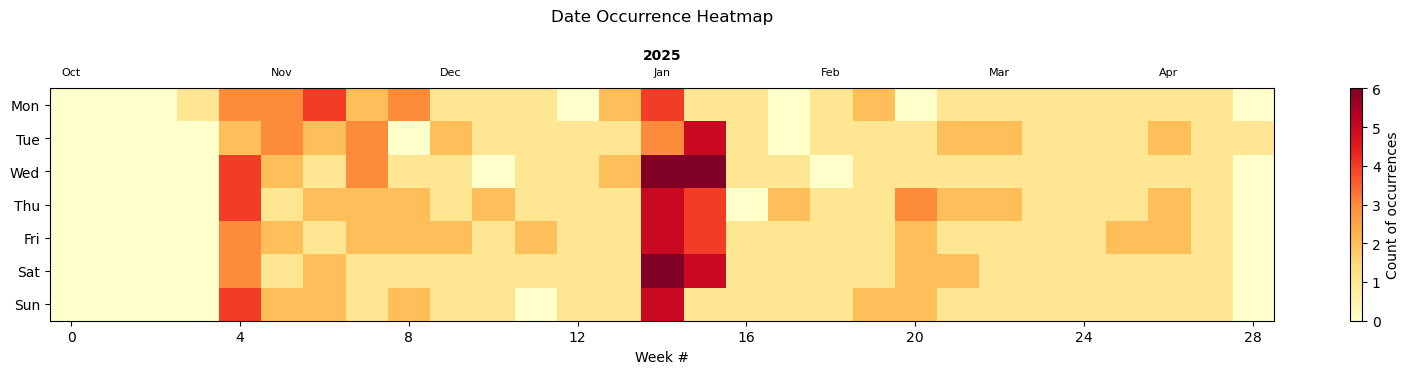

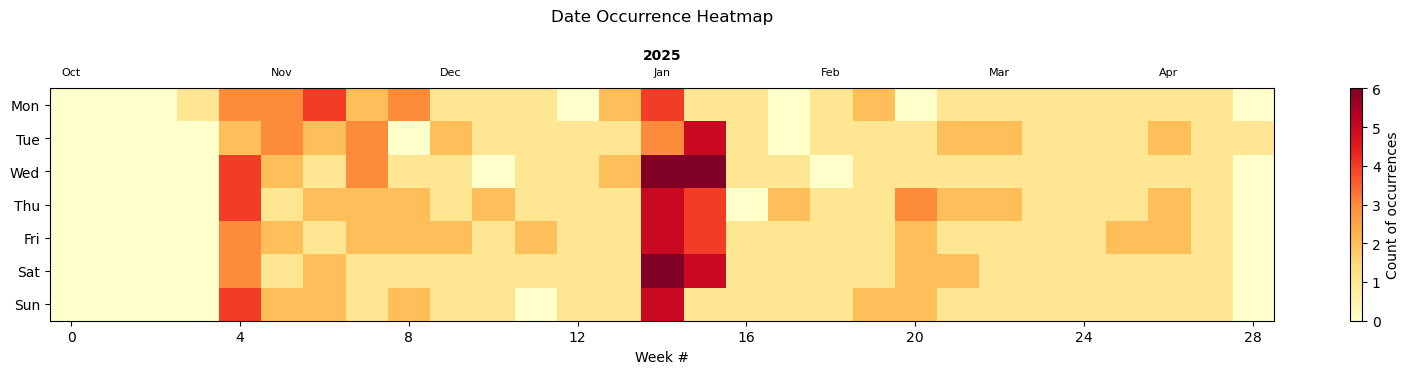

In [108]:
# Convert Series to list of dates
dates = get_type_data(full_df,"diaper")['enteredDate'].dt.date
ax=make_year_heatmap(dates)
plt.sca(ax)
plt.savefig("figures/diapers_map.png")

29


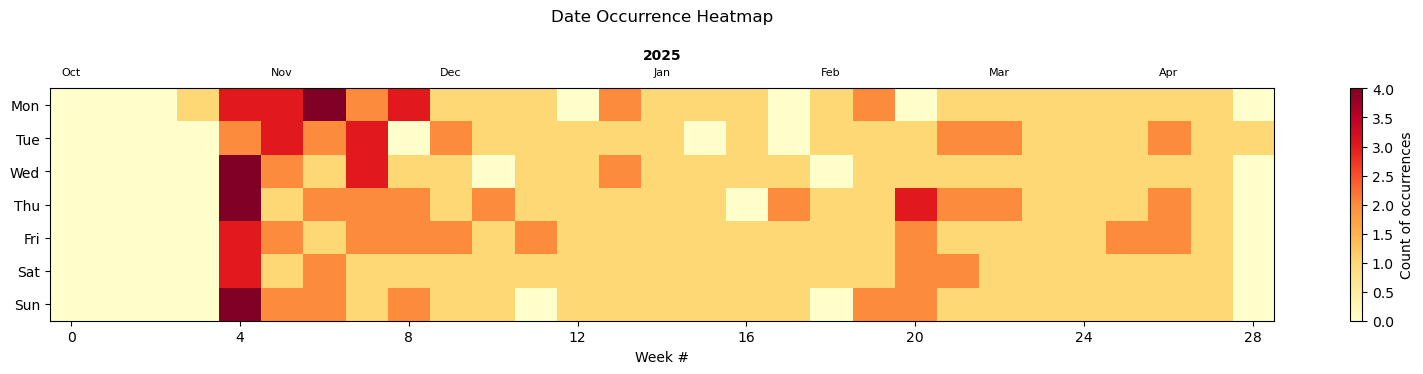

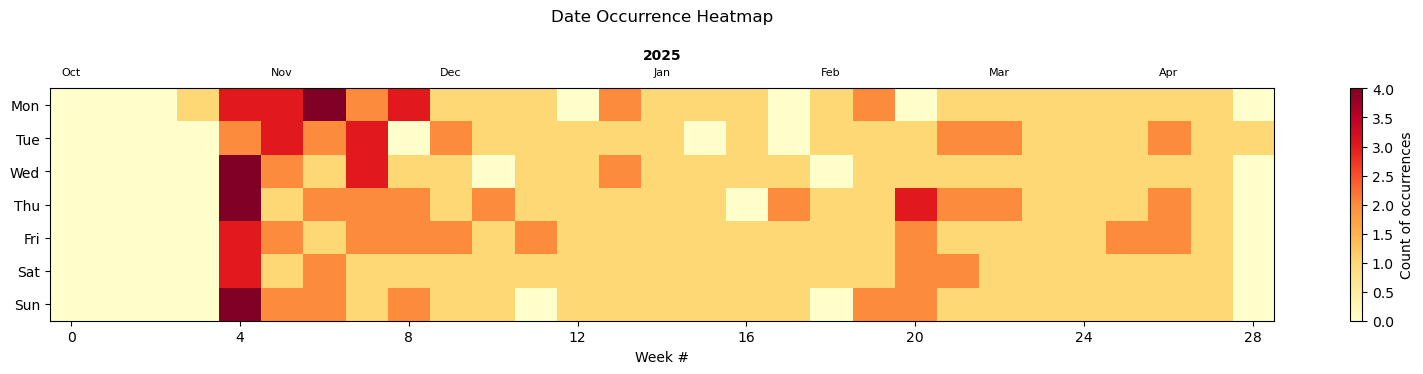

In [109]:
dates=get_type_data(full_df,"diaper").query("customComment=='dirty'")['enteredDate'].dt.date
ax=make_year_heatmap(dates)
plt.sca(ax)
plt.savefig("figures/diapers_map.png")